# Business Understading


# BO1 : Prédire les coûts médicaux pour anticiper les dépenses

Prédire le coût médical des assurés afin d’optimiser la tarification, réduire les risques et automatiser le processus.

DSO1 : Construire un modèle de régression prédictive avec une MAE < 3 000 $ pour estimer les charges médicales à partir des données clients.

Méthodes envisagées : Régression linéaire, Random Forest, XGBoost, Réseaux de neurones.

# **BO2 : Identifier les assurés « atypiques »**

Détecter les profils dont les caractéristiques diffèrent fortement de la majorité.

DSO2 : Détection d’anomalies globales (variables numériques + catégorielles).

Méthodes envisagées :

Isolation Forest (robuste et scalable)

One-Class SVM (frontière inliers/outliers)

# BO3 : Évaluer et répartir les charges de soins et Segmenter et catégoriser la clientèle

Analyser la répartition des charges de soins pour optimiser les ressources et améliorer la qualité de prise en charge.

DSO3 : Analyse statistique et exploration visuelle des charges (distribution, outliers, corrélations).


Identifier et classer les clients selon leurs besoins, habitudes et profils pour personnaliser l’accompagnement et améliorer l’expérience assurée.

 Mettre en place un clustering (K-Means, DBSCAN, GMM) pour créer des segments homogènes de clients.

# BO4 : Détecter les jeunes assurés à risque élevé

Identifier les jeunes assurés présentant un profil de risque afin de les intégrer dans des programmes de prévention ciblés.

DSO4 : Construire un modèle de classification supervisée multi-classes pour détecter ces profils.

# Understading Data



This cell imports the main Python libraries used throughout the notebook:

NumPy for numerical operations

Pandas for data manipulation and analysis

Matplotlib for plotting and visualization
It then loads the dataset dataAssurance.csv into a Pandas DataFrame named data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
data=pd.read_csv("dataAssurance.csv")

we are defining a function If the DataFrame has more than 500 rows, it only shows the first limit rows (default: 20).
This prevents overwhelming outputs for large datasets.

In [ ]:
def show_table(title: str, frame: pd.DataFrame, head_only_if_big=True, limit=20):
    print(f"\n=== {title} ===")
    if head_only_if_big and len(frame) > 500:
        display(frame.head(limit))
        print(f"... ({len(frame)} rows total)")
    else:
        display(frame)

Here, a function iqr_outlier_count is defined to detect outliers using the Interquartile Range (IQR) method.

In [ ]:
def iqr_outlier_count(series: pd.Series) -> int:
    s = series.dropna()
    if s.empty:
        return 0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return int(((series < lower) | (series > upper)).sum())

data → displays the full dataset.

In [ ]:
data

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1438,35.0,female,27.700,3.0,no,southwest,6414.17800
1439,36.0,female,26.885,0.0,no,northwest,5267.81815
1440,60.0,female,38.060,0.0,no,southeast,12648.70340
1441,20.0,male,NaN,1.0,no,southeast,27724.28875


info() → gives structure: number of entries, columns, and memory usage.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1406 non-null   float64
 1   sex       1405 non-null   object 
 2   bmi       1410 non-null   float64
 3   children  1414 non-null   float64
 4   smoker    1417 non-null   object 
 5   region    1410 non-null   object 
 6   charges   1414 non-null   float64
dtypes: float64(4), object(3)
memory usage: 79.0+ KB


describe() → computes descriptive statistics (mean, std, min, quartiles, max).

In [ ]:
data.describe()

,age,bmi,children,charges
count,1406.000000,1410.000000,1414.000000,1414.000000
mean,39.179232,30.637681,1.086280,13179.307173
std,14.067120,6.112450,1.196088,11987.371506
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4748.057175
50%,39.000000,30.302500,1.000000,9369.615750
75%,51.000000,34.656250,2.000000,16547.261588
max,64.000000,53.130000,5.000000,63770.428010


dtypes → lists column data types.

In [ ]:
data.dtypes

,0
age,float64
sex,object
bmi,float64
children,float64
smoker,object
region,object
charges,float64


isna().sum() → counts missing values per column.

In [ ]:
data.isna().sum()

,0
age,37
sex,38
bmi,33
children,29
smoker,26
region,33
charges,29


calculates the percentage of missing values, assuming the dataset has 1443 rows.

In [ ]:
(data.isna().sum()/1443)*100

,0
age,2.564103
sex,2.633403
bmi,2.286902
children,2.009702
smoker,1.801802
region,2.286902
charges,2.009702


most of our Nan values are either equal 2% or less
This cell calculates the number of unique values in each column, including NaN.
It stores the result in a new DataFrame unique_df


In [ ]:
unique_counts = data.nunique(dropna=False)
unique_df = (
    pd.DataFrame({"unique_count_including_NaN": unique_counts})
    .rename_axis("column")
    .reset_index()
    .sort_values("unique_count_including_NaN", ascending=False)
)
show_table("04 - Unique counts per column", unique_df, head_only_if_big=False)


=== 04 - Unique counts per column ===


,column,unique_count_including_NaN
6,charges,1310
2,bmi,544
0,age,48
3,children,7
5,region,5
1,sex,3
4,smoker,3


###  Identify numeric columns & summarize

**What this does**

- Selects **numeric features** with `select_dtypes`.
- Builds a quick **per-column summary** (count, missing, unique).
- Prepares lists used later for plots, correlations, and outlier checks.

ACP/ACM


In [ ]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_summary = data[num_cols].describe().T
num_summary["skew"] = data[num_cols].skew(numeric_only=True)
num_summary["kurtosis"] = data[num_cols].kurtosis(numeric_only=True)
show_table("05 - Numerical summary (with skew/kurtosis)",
           num_summary.round(4).rename_axis("column").reset_index(), head_only_if_big=False)


=== 05 - Numerical summary (with skew/kurtosis) ===


,column,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,age,1406.0,39.1792,14.0671,18.0000,26.0000,39.0000,51.0000,64.000,0.0645,-1.2416
1,bmi,1410.0,30.6377,6.1125,15.9600,26.2200,30.3025,34.6562,53.130,0.3081,-0.0059
2,children,1414.0,1.0863,1.1961,0.0000,0.0000,1.0000,2.0000,5.000,0.9418,0.2206
3,charges,1414.0,13179.3072,11987.3715,1121.8739,4748.0572,9369.6158,16547.2616,63770.428,1.5364,1.7230


SKew determines the symetry of our data
and Kurtosis show us which data has outliers so we can work on them :D

---



###  Identify categorical columns & value counts

**What this does**

- Collects **categorical features** (object/category dtypes).
- Computes **value counts** (including NaN) to gauge class balance and rare categories.

In [ ]:
cat_cols = data.select_dtypes(include=["object", "category"]).columns.tolist()
for c in cat_cols:
    vc  = data[c].value_counts(dropna=False, normalize=False)
    vcp = (data[c].value_counts(dropna=False, normalize=True) * 100).round(4)
    cat_value_counts = pd.DataFrame({"count": vc, "percentage_%": vcp}).rename_axis(c).reset_index()
    show_table(f"06 - Value counts for '{c}' (incl. NaN)", cat_value_counts)


=== 06 - Value counts for 'sex' (incl. NaN) ===


,sex,count,percentage_%
0,male,719,49.8267
1,female,686,47.5398
2,NaN,38,2.6334



=== 06 - Value counts for 'smoker' (incl. NaN) ===


,smoker,count,percentage_%
0,no,1132,78.4477
1,yes,285,19.7505
2,NaN,26,1.8018



=== 06 - Value counts for 'region' (incl. NaN) ===


,region,count,percentage_%
0,southeast,381,26.4033
1,northwest,345,23.9085
2,southwest,344,23.8392
3,northeast,340,23.5620
4,NaN,33,2.2869


### Duplicate rows: count & preview


- Counts **duplicate rows** and shows a sample of them.
- Helps decide whether to **drop duplicates** as part of cleaning.

In [ ]:
dupes = int(data.duplicated().sum())
show_table("07 - Duplicate row count", pd.DataFrame({"duplicate_rows":[dupes]}), head_only_if_big=False)



=== 07 - Duplicate row count ===


,duplicate_rows
0,105


**What this does**

- Performs a step in the EDA/cleaning/modelling workflow.
- Outputs intermediate artifacts for verification (tables or plots).

In [ ]:
duplicates_df = data[data.duplicated(keep=False)]

show_table("07 - Duplicate rows", duplicates_df, head_only_if_big=False)


=== 07 - Duplicate rows ===


,age,sex,bmi,children,smoker,region,charges
9,60.0,female,25.840,0.0,no,northwest,28923.13692
23,34.0,female,31.920,1.0,yes,northeast,37701.87680
24,37.0,male,28.025,2.0,no,northwest,6203.90175
30,22.0,male,35.600,0.0,yes,southwest,35585.57600
44,NaN,male,37.050,1.0,no,northeast,6079.67150
...,...,...,...,...,...,...,...
1438,35.0,female,27.700,3.0,no,southwest,6414.17800
1439,36.0,female,26.885,0.0,no,northwest,5267.81815
1440,60.0,female,38.060,0.0,no,southeast,12648.70340
1441,20.0,male,NaN,1.0,no,southeast,27724.28875


we need to remove the duplicated data to ensure the consistency of the model


### Outlier detection (IQR method)

- Uses **IQR (Interquartile Range)** to count outliers per numeric column.
- Outliers fall outside `[Q1−1.5×IQR, Q3+1.5×IQR]`.

In [ ]:
outliers = {c: iqr_outlier_count(data[c]) for c in num_cols}
outliers_df = pd.DataFrame(list(outliers.items()), columns=["column", "iqr_outlier_count"])\
                .sort_values("iqr_outlier_count", ascending=False)
show_table("08 - IQR outlier counts (numeric columns)", outliers_df, head_only_if_big=False)


=== 08 - IQR outlier counts (numeric columns) ===


,column,iqr_outlier_count
3,charges,145
1,bmi,10
0,age,0
2,children,0


- Computes pairwise **Pearson correlations** among numeric features.
- Useful to spot **multicollinearity** and relationships with the target (if numeric).

In [ ]:
if len(num_cols) >= 2:
    corr_df = data[num_cols].corr().round(3)
    show_table("09 - Correlation matrix (numeric)", corr_df)


=== 09 - Correlation matrix (numeric) ===


,age,bmi,children,charges
age,1.000,0.113,0.034,0.302
bmi,0.113,1.000,0.001,0.200
children,0.034,0.001,1.000,0.051
charges,0.302,0.200,0.051,1.000


### this is a function that :

- Performs a step in the EDA/cleaning/modelling workflow.
- Outputs intermediate artifacts for verification (tables or plots).

In [ ]:
def show_table(title: str, frame: pd.DataFrame, head_only_if_big=True, limit=20):
    print(f"\n=== {title} ===")
    if head_only_if_big and len(frame) > 500:
        display(frame.head(limit))
        print(f"... ({len(frame)} rows total)")
    else:
        display(frame)


now we wat to show our data in diagrammes and frames



### Distributions of numeric features (histograms)

- Plots **histograms** for each numeric column to visualize distribution shape.
- Helps identify **skew**, **outliers**, and candidate transforms.

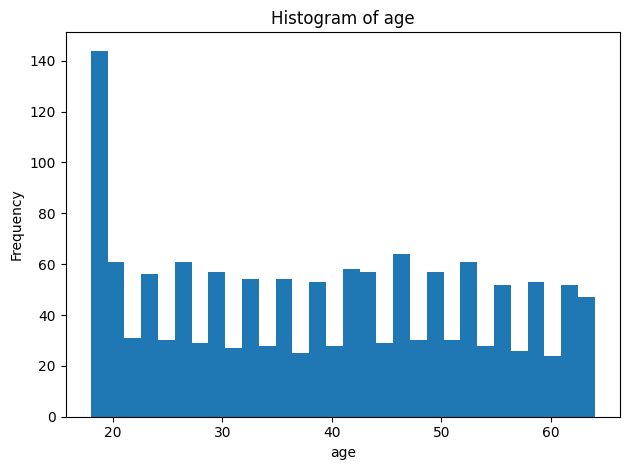

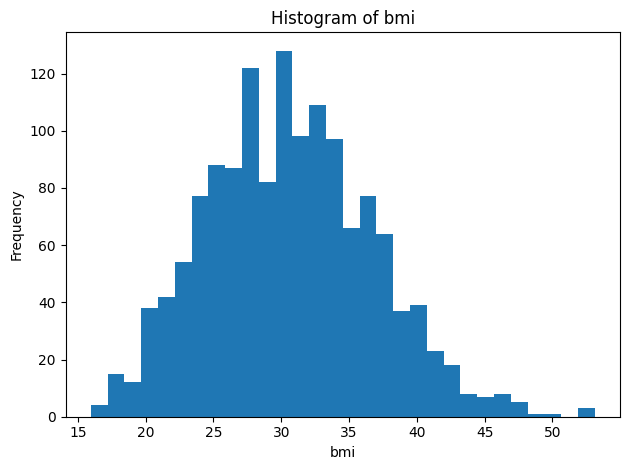

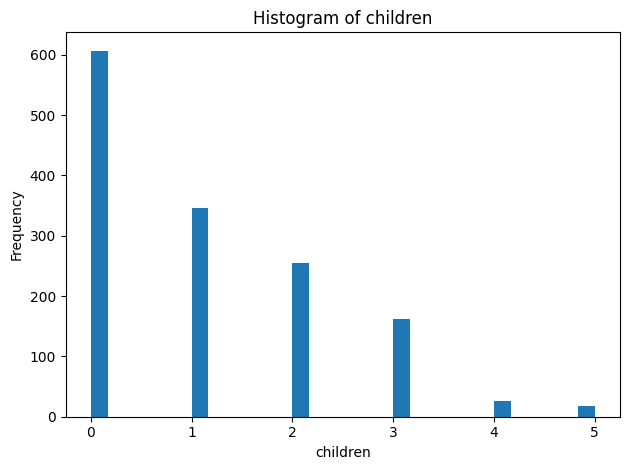

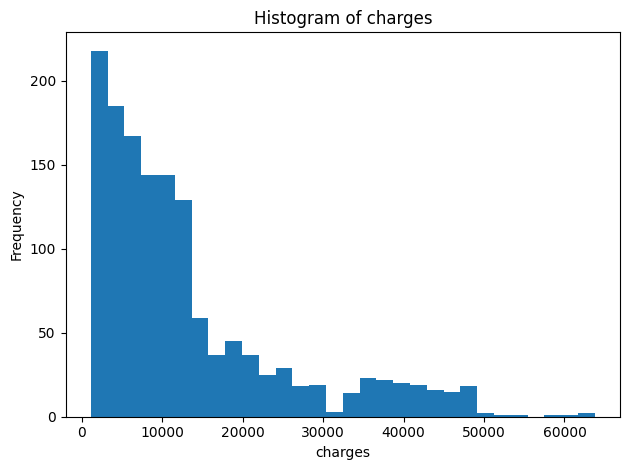

In [ ]:
for col in num_cols:
    plt.figure()
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### Cell 24: Boxplots of numeric features


/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


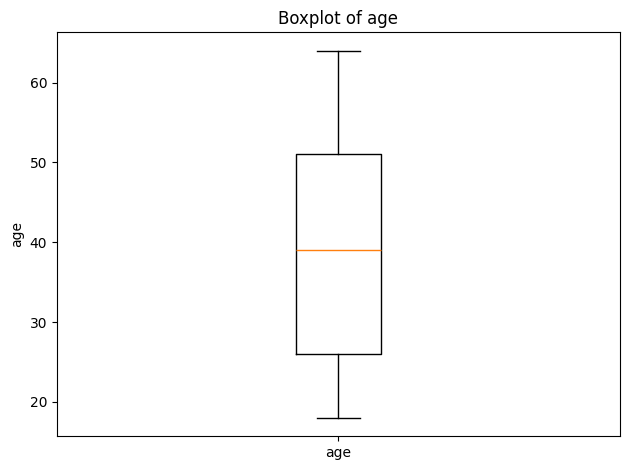

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


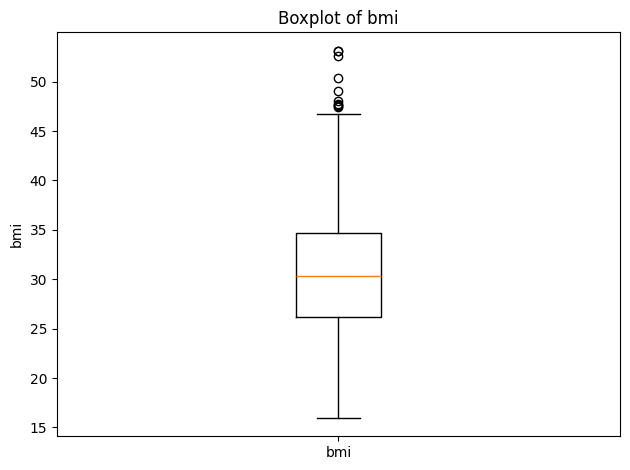

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


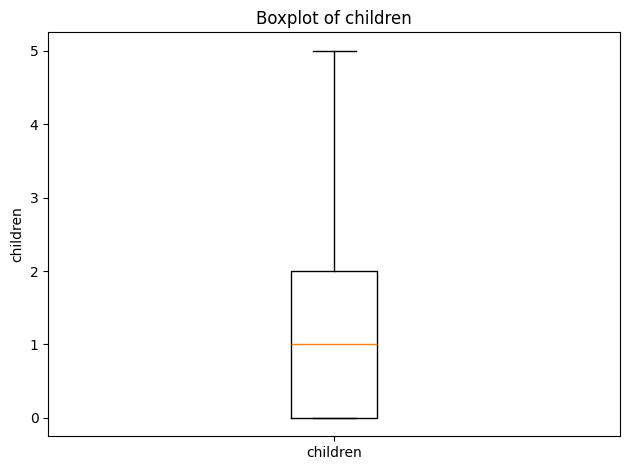

/tmp/ipython-input-1336958216.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[col].dropna(), vert=True, labels=[col])


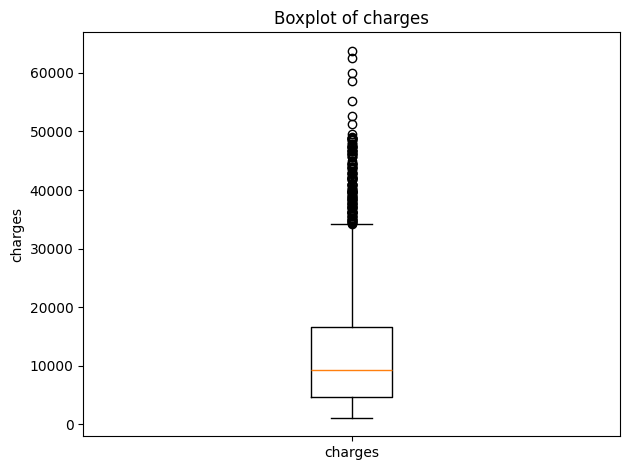

In [ ]:
for col in num_cols:
    plt.figure()
    plt.boxplot(data[col].dropna(), vert=True, labels=[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

- Performs a step in the EDA/cleaning/modelling workflow.
- Outputs intermediate artifacts for verification (tables or plots).

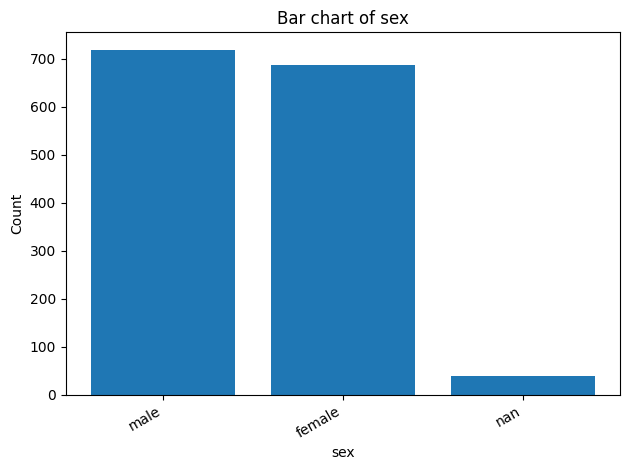

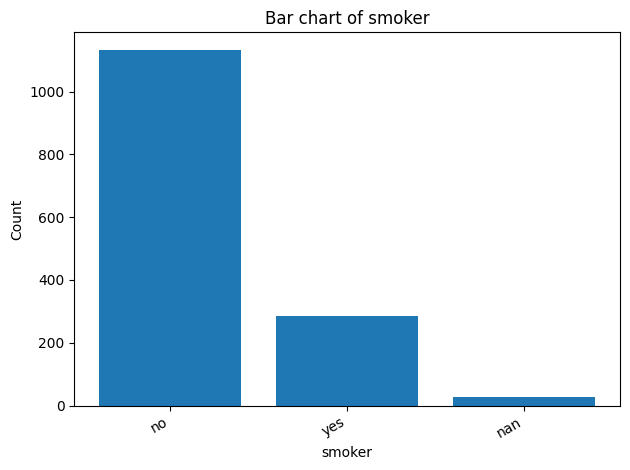

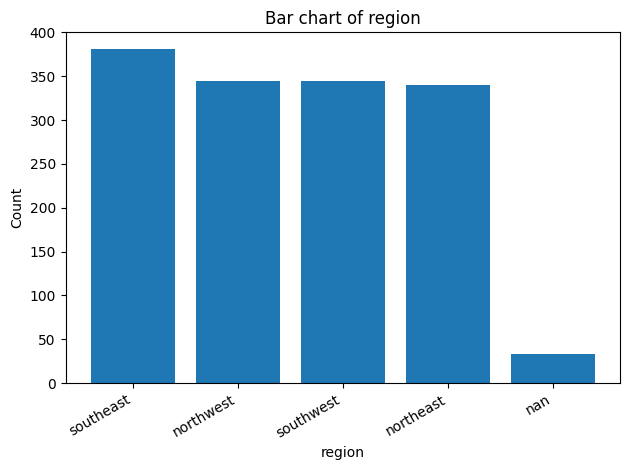

In [ ]:
for col in cat_cols:
    plt.figure()
    counts = data[col].value_counts(dropna=False)
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Bar chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

### Feature vs Charges: scatter

- Visualizes relationship between a feature (e.g., BMI) and **charges**.
- Useful to sense **trend**, **heteroscedasticity**, or non-linear patterns.

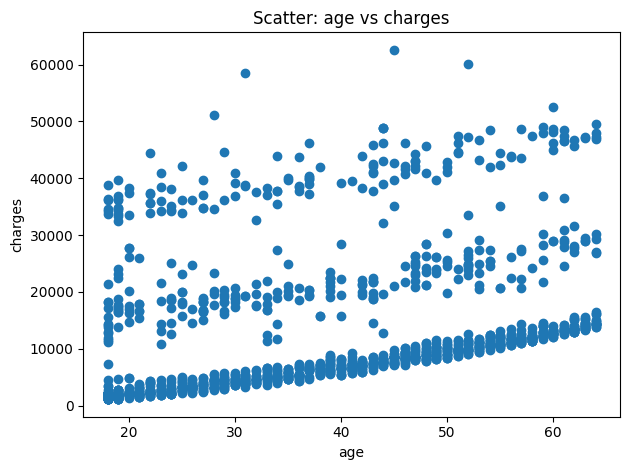

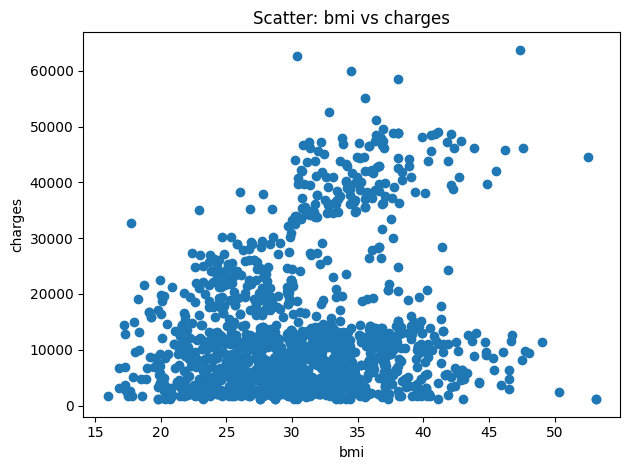

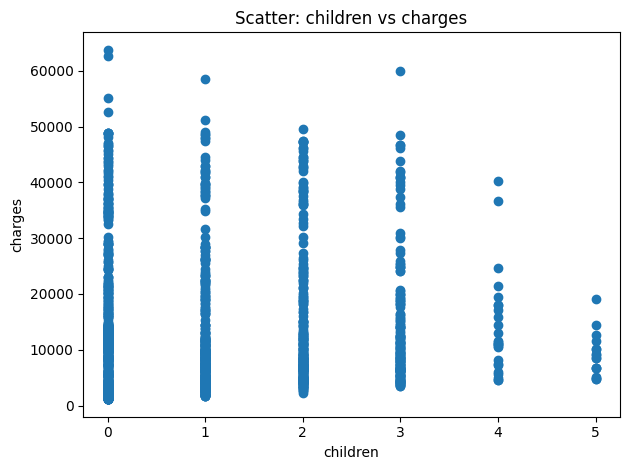

In [ ]:
if "charges" in num_cols:
    for col in [c for c in num_cols if c != "charges"]:
        plt.figure()
        plt.scatter(data[col], data["charges"])
        plt.title(f"Scatter: {col} vs charges")
        plt.xlabel(col)
        plt.ylabel("charges")
        plt.tight_layout()
        plt.show()

In [ ]:
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Rows: 1443, Columns: 7
Numeric columns: ['age', 'bmi', 'children', 'charges']
Categorical columns: ['sex', 'smoker', 'region']


- Selects **numeric features** with `select_dtypes`.
- Builds a quick **per-column summary** (count, missing, unique).
- Prepares lists used later for plots, correlations, and outlier checks.
- Counts **duplicate rows** and shows a sample of them.
- Helps decide whether to **drop duplicates** as part of cleaning.
- Uses **IQR (Interquartile Range)** to count outliers per numeric column.
- Outliers fall outside `[Q1−1.5×IQR, Q3+1.5×IQR]`.
- Computes pairwise **Pearson correlations** among numeric features.
- Useful to spot **multicollinearity** and relationships with the target (if numeric).
- Applies **One‑Hot Encoding** for nominal variables to make them usable by models.
- Drops the first dummy to avoid the **dummy variable trap**.
- Computes missing‑value **percentages** for numeric & categorical columns.
- Guides imputation strategy and feature removal decisions.


In [ ]:
missing_percentage_num = data.select_dtypes(include=[np.number]).isna().mean().mean()
missing_percentage_cat = data.select_dtypes(include=['object']).isna().mean().mean()
duplicates_percentage = data.duplicated().mean()
variances = data.select_dtypes(include=[np.number]).var()
low_variance_columns = variances[variances < 0.01].count()
outlier_threshold = 0.1  # <10% it is considered bad
outliers_percentage = (data.select_dtypes(include=[np.number])
                       .apply(lambda x: ((x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) |
                                         (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))))).mean()))
outlier_impact = (outliers_percentage > outlier_threshold).sum()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
encoded_data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)  # no dummy variable trap
corr_matrix = encoded_data.corr().abs()  # Use absolute correlation values
high_corr = (corr_matrix > 0.9).sum().sum() - len(corr_matrix)  # excluding self-correlation age with age for example
missing_score = 1 - missing_percentage_num
duplicates_score = 1 - duplicates_percentage
variance_score = 1 - (low_variance_columns / len(variances))  # lower variance = worse score
outlier_score = 1 - (outlier_impact / len(data.select_dtypes(include=[np.number])))  # More outliers = worse score
correlation_score = 1 - (high_corr / len(corr_matrix))  # More high correlations = worse score
data_quality_score = np.mean([missing_score, duplicates_score, variance_score, outlier_score, correlation_score])
print(f"\n=== Data Quality Score ===")
print(f"Data Quality Score: {data_quality_score:.4f}")
print("\n--- Breakdown of Data Quality Components ---")
print(f"Missing Data Score: {missing_score:.4f}")
print(f"Duplicates Score: {duplicates_score:.4f}")
print(f"Low Variance Feature Score: {variance_score:.4f}")
print(f"Outlier Impact Score: {outlier_score:.4f}")
print(f"Correlation Impact Score: {correlation_score:.4f}")



=== Data Quality Score ===
Data Quality Score: 0.9809

--- Breakdown of Data Quality Components ---
Missing Data Score: 0.9778
Duplicates Score: 0.9272
Low Variance Feature Score: 1.0000
Outlier Impact Score: 0.9993
Correlation Impact Score: 1.0000


We can assume our data is decent and using it we can arrive to some solid results


# DATA PREPARATION


### Datatype audit

- Prints **dtypes** after transformations to confirm expected numeric/categorical types.

In [ ]:
data.dtypes

,0
age,float64
sex,object
bmi,float64
children,float64
smoker,object
region,object
charges,float64


let's drop duplicates first

1.   List ite
2.   List item




In [ ]:
data=data.drop_duplicates()

NAN treatement


for the qualitative features we opted to use mode to keep the dominant categorie as dominant

In [ ]:
cat_features = ['sex','smoker','region']
for col in cat_features:
    data[col].fillna(data[col].mode()[0], inplace=True)

/tmp/ipython-input-2472138509.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
/tmp/ipython-input-2472138509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mode()[0], inplace=True)


In [ ]:
data.isna().sum()

,0
age,34
sex,0
bmi,31
children,27
smoker,0
region,0
charges,28


Numerical columns: Imputed with the median (we showed that data is skewed)

### Post‑imputation null check

- Selects **numeric features** with `select_dtypes`.
- Builds a quick **per-column summary** (count, missing, unique).
- Prepares lists used later for plots, correlations, and outlier checks.
- Uses scikit‑learn **SimpleImputer** for consistent, pipeline‑friendly imputation.
- Verifies that missing values were handled as expected.

In [ ]:
from sklearn.impute import SimpleImputer
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numeric_imputer = SimpleImputer(strategy="median")
data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])
categorical_imputer = SimpleImputer(strategy="most_frequent")
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])
print(f"After imputation, any remaining missing values? {data.isna().sum().sum()}")
show_table("After Imputation: Sample Data", data.head())

After imputation, any remaining missing values? 0

=== After Imputation: Sample Data ===


/tmp/ipython-input-883454174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])
/tmp/ipython-input-883454174.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


### Feature vs Charges: scatter

- Visualizes relationship between a feature (e.g., BMI) and **charges**.
- Useful to sense **trend**, **heteroscedasticity**, or non-linear patterns.

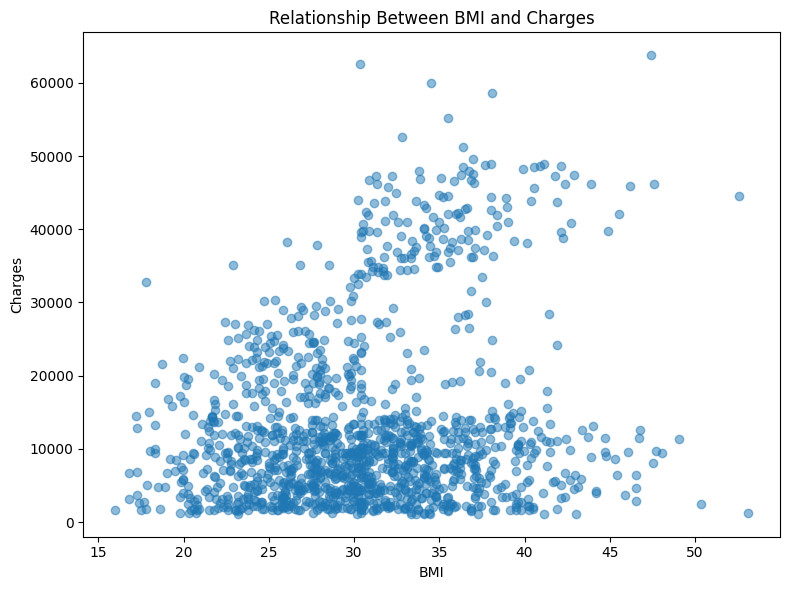

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data['bmi'], data['charges'], alpha=0.5)
plt.title("Relationship Between BMI and Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.tight_layout()
plt.show()

After our investigation ;p we noticed that some charges outliers are connected to a bmi outliers,and we for that we had made the decesion the keep some outliers because of the great significance to our objective

### Outlier detection (IQR method)

- Uses **IQR (Interquartile Range)** to count outliers per numeric column.
- Outliers fall outside `[Q1−1.5×IQR, Q3+1.5×IQR]`.

In [ ]:
Q1_bmi = data['bmi'].quantile(0.25)
Q3_bmi = data['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
lower_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bmi = Q3_bmi + 1.5 * IQR_bmi

# 2) Identify charges outliers (above 99th percentile)
charge_99th_percentile = data['charges'].quantile(0.99)
charge_outliers = data['charges'] > charge_99th_percentile

# 3) Keep charges outliers only if the BMI is also an outlier
bmi_outliers = (data['bmi'] < lower_bmi) | (data['bmi'] > upper_bmi)

# 4) Remove charges outliers if the corresponding BMI is not an outlier
data_cleaned = data[~(charge_outliers & ~bmi_outliers)]  # Remove charges outliers that are not BMI outliers

# 5) Verify the result after cleaning
show_table("After Removing Charges Outliers (not related to BMI outliers)", data_cleaned.head())


=== After Removing Charges Outliers (not related to BMI outliers) ===


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


### Label encoding selected columns

- Applies **One‑Hot Encoding** for nominal variables to make them usable by models.
- Drops the first dummy to avoid the **dummy variable trap**.
- Uses **LabelEncoder** (ordinal IDs) for specific columns where integer labels are acceptable.

In [ ]:
data_encoded = pd.get_dummies(data_cleaned, columns=['sex', 'smoker'], drop_first=True)

# Convert all boolean dummies to int (0/1)
for col in ['sex_male', 'smoker_yes']:
    data_encoded[col] = data_encoded[col].astype(int)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data_encoded['region'] = label_encoder.fit_transform(data_encoded['region'])

print(data_encoded.head())


    age     bmi  children  region      charges  sex_male  smoker_yes
0  19.0  27.900       0.0       3  16884.92400         0           1
1  18.0  33.770       1.0       2   1725.55230         1           0
2  28.0  33.000       3.0       2   4449.46200         1           0
3  33.0  22.705       0.0       1  21984.47061         1           0
4  32.0  28.880       0.0       1   3866.85520         1           0


In [ ]:
show_table("After One-Hot and Label Encoding", data_encoded.head())



=== After One-Hot and Label Encoding ===


,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0


In [ ]:
data_encoded.dtypes

,0
age,float64
bmi,float64
children,float64
region,int64
charges,float64
sex_male,int64
smoker_yes,int64


#Feature engineering

### PCA (dimensionality reduction)

- Runs **Principal Component Analysis** on scaled data.
- Reports **explained variance ratio** per component to judge compression quality.



In [ ]:
# ===================== PCA FOR ALL FEATURES =====================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)  # Apply on all the encoded features
pca = PCA(n_components=len(data_encoded.columns))  # Keep all components to explain each feature's weight
pca.fit(data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
feature_weights = pd.DataFrame(pca.components_, columns=data_encoded.columns)
print("\nExplained Variance Ratio (Contribution of each component):")
print(explained_variance_ratio)
show_table("Feature Weights for All Principal Components", feature_weights)
first_pc_weights = feature_weights.iloc[0].abs().sort_values(ascending=False)
print("\nFeatures with the most influence on the first principal component:")
print(first_pc_weights)





Explained Variance Ratio (Contribution of each component):
[0.26043205 0.16981696 0.15048426 0.14238015 0.13771196 0.11544167
 0.02373295]

=== Feature Weights for All Principal Components ===


,age,bmi,children,region,charges,sex_male,smoker_yes
0,0.231103,0.174365,0.074313,0.011522,0.706421,0.094119,0.634543
1,0.374489,0.641426,0.196142,0.562044,-0.034327,-0.030586,-0.303071
2,0.636524,-0.195974,0.265745,-0.421747,0.061437,-0.516560,-0.193215
3,-0.010378,-0.096446,0.776459,-0.171880,-0.052306,0.589823,-0.086784
4,0.422374,0.179814,-0.517940,-0.385481,-0.015234,0.574978,-0.203908
5,-0.394792,0.678088,0.111421,-0.571551,0.005355,-0.211734,-0.019771
6,-0.258493,-0.135373,-0.042673,0.035978,0.702154,0.007040,-0.647047



Features with the most influence on the first principal component:
charges       0.706421
smoker_yes    0.634543
age           0.231103
bmi           0.174365
sex_male      0.094119
children      0.074313
region        0.011522
Name: 0, dtype: float64


In [ ]:
# 1. Save non-encoded cleaned dataset
data_cleaned.to_csv("data_cleaned.csv", index=False)

# 2. Save encoded cleaned dataset
data_encoded.to_csv("data_encoded.csv", index=False)

# 3. Download both
from google.colab import files
files.download("data_cleaned.csv")
files.download("data_encoded.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_encoded

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0
...,...,...,...,...,...,...,...
1333,50.0,30.970,3.0,1,10600.54830,1,0
1334,18.0,31.920,0.0,0,2205.98080,0,0
1335,18.0,36.850,0.0,2,1629.83350,0,0
1336,21.0,25.800,0.0,3,2007.94500,0,0


In [ ]:
data_cleaned

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,northwest,10600.54830
1334,18.0,female,31.920,0.0,no,northeast,2205.98080
1335,18.0,female,36.850,0.0,no,southeast,1629.83350
1336,21.0,female,25.800,0.0,no,southwest,2007.94500


# Modeling and evaluation

*Supervised Model*

1. Construire un modèle prédictive pour estimer les charges médicales à partir des données clients.

Modele 1:

                            Model          MAE         RMSE        R2
6  PolynomialRegression(degree=2)  3128.200862  5387.242511  0.772550
5                GradientBoosting  2998.680684  5586.161756  0.755443
4                    RandomForest  3290.002001  5991.461272  0.718668
1                           Ridge  4532.148082  6749.668397  0.642959
0                LinearRegression  4531.453110  6749.730067  0.642953
2                           Lasso  4531.427108  6749.735377  0.642952
3                    DecisionTree  4270.364666  8529.797155  0.429796


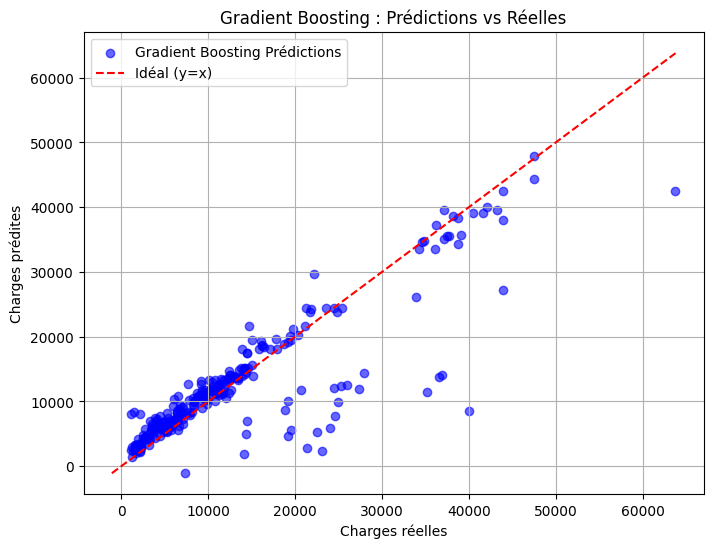

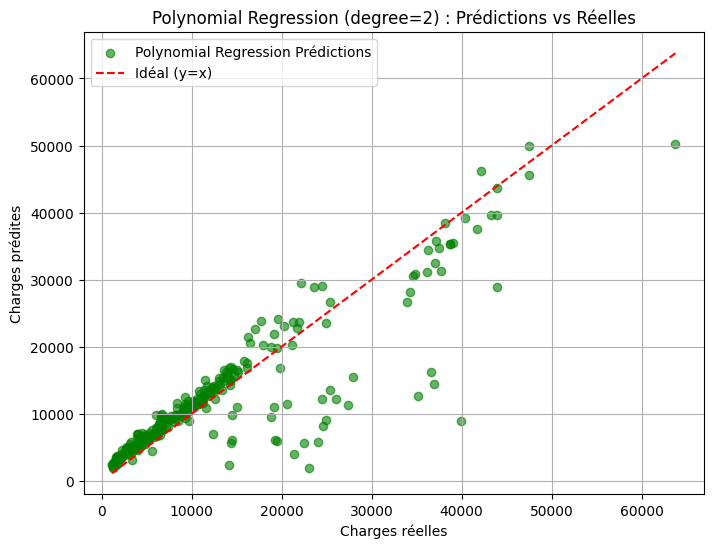

In [ ]:
# Séparer features et target (après encodage)
X = data_encoded.drop('charges', axis=1)
y = data_encoded['charges']

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# -------------------------------
#  Définir les modèles
# -------------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# -------------------------------
# bis Polynomial Regression
# -------------------------------
poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# -------------------------------
#  Entraîner et évaluer les modèles
# -------------------------------
results = []

for name, model in models.items():
    if name in ["LinearRegression", "Ridge", "Lasso"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

# Évaluer Polynomial Regression
poly_model.fit(X_train, y_train)  # on peut aussi utiliser X_train_scaled si nécessaire
y_pred_poly = poly_model.predict(X_test)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

results.append({
    "Model": "PolynomialRegression(degree=2)",
    "MAE": mae_poly,
    "RMSE": rmse_poly,
    "R2": r2_poly
})

# -------------------------------
#  Afficher les résultats
# -------------------------------
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)

# -------------------------------
#  Visualisation scatter pour Gradient Boosting et Polynomial Regression
# -------------------------------
# Gradient Boosting
gb_model = models["GradientBoosting"]
y_pred_gb = gb_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_gb, alpha=0.6, color="blue", label="Gradient Boosting Prédictions")
lims = [min(y_test.min(), y_pred_gb.min()), max(y_test.max(), y_pred_gb.max())]
plt.plot(lims, lims, 'r--', label="Idéal (y=x)")
plt.xlabel("Charges réelles")
plt.ylabel("Charges prédites")
plt.title("Gradient Boosting : Prédictions vs Réelles")
plt.legend()
plt.grid(True)
plt.show()

# Polynomial Regression
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_poly, alpha=0.6, color="green", label="Polynomial Regression Prédictions")
lims = [min(y_test.min(), y_pred_poly.min()), max(y_test.max(), y_pred_poly.max())]
plt.plot(lims, lims, 'r--', label="Idéal (y=x)")
plt.xlabel("Charges réelles")
plt.ylabel("Charges prédites")
plt.title("Polynomial Regression (degree=2) : Prédictions vs Réelles")
plt.legend()
plt.grid(True)
plt.show()

Modele2 :

Shape: Train=(1060, 8), Test=(265, 8)
Features utilisées (y compris FE): ['age', 'bmi', 'children', 'region', 'sex_male', 'smoker_yes', 'bmi_30_smoker', 'age_smoker_interaction']

[GBoosting (Base)]
CV MAE   : 3099.97
Test MAE : 3009.42
Test R2  : 0.762

--- Lancement de la recherche d'hyperparamètres pour Gradient Boosting (50 itérations)... ---

✅ Recherche terminée.
Meilleurs hyperparamètres trouvés:
{'learning_rate': np.float64(0.06867511656638482), 'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 114}

[GBoosting (Optimisé)]
CV MAE   : 2931.58
Test MAE : 2992.90
Test R2  : 0.764

=== Résumé des Modèles Gradient Boosting ===
                  Model       CV MAE     Test MAE   Test R2
1  GBoosting (Optimisé)  2931.581383  2992.902454  0.764064
0      GBoosting (Base)  3099.972941  3009.416058  0.761725


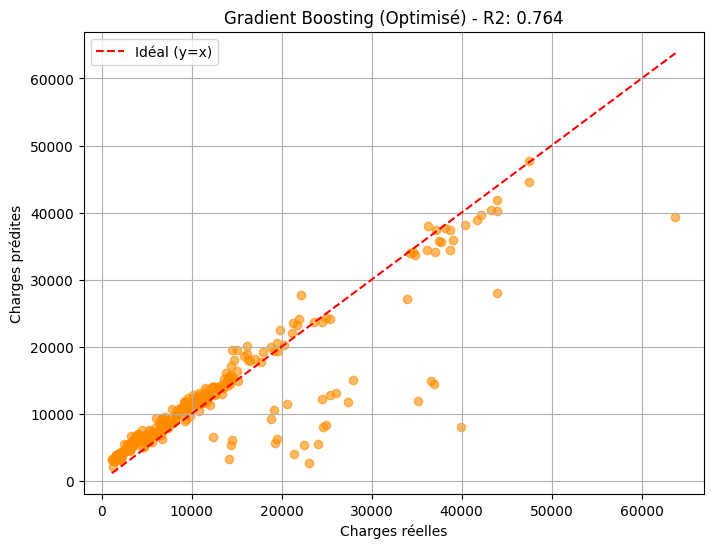

In [ ]:
# =======================================================================
# === BLOC COMPLET : Du Feature Engineering à l'Optimisation du Modèle ===
# =======================================================================

# === 1. Imports & Setup ===
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings
warnings.filterwarnings('ignore') # Masquer les warnings

# --- Chemin du dataset (assurez-vous que 'data_encoded.csv' est disponible) ---
try:
    DATA_PATH = Path("data_encoded.csv")
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print("Erreur: Le fichier 'data_encoded.csv' est manquant.")
    exit()

# === 2. Feature Engineering (Création de Variables d'Interaction) ===
# Les colonnes 'sex_male', 'smoker_yes', 'region' sont déjà encodées.
# Création d'une variable cruciale pour ce jeu de données: l'interaction fumeur/IMC
df['bmi_30_smoker'] = df.apply(
    lambda row: 1 if (row['smoker_yes'] == 1 and row['bmi'] >= 30) else 0,
    axis=1
)
# Création de l'interaction âge/fumeur (Age * Smoker)
df['age_smoker_interaction'] = df['age'] * df['smoker_yes']


# === 3. Préparation des Données et Split ===
TARGET = "charges"
X = df.drop(columns=[TARGET]) # Features, incluant les nouvelles FE
y = df[TARGET].values        # Target

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Shape: Train={X_train.shape}, Test={X_test.shape}")
print(f"Features utilisées (y compris FE): {X_train.columns.tolist()}")


# === 4. Fonction d'Évaluation ===
def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=5):
    """
    Entraîne et évalue un modèle de régression.
    """
    # Cross-validation (MAE)
    cv_scores = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1
    )
    cv_mae = -np.mean(cv_scores)

    # Fit et prédiction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Scores test
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    print(f"\n[{name}]")
    print(f"CV MAE   : {cv_mae:.2f}")
    print(f"Test MAE : {test_mae:.2f}")
    print(f"Test R2  : {test_r2:.3f}")

    return {
        "Model": name,
        "CV MAE": cv_mae,
        "Test MAE": test_mae,
        "Test R2": test_r2,
        "Pred": y_pred,
        "model_obj": model
    }

results = []
# Évaluation du modèle de base Gradient Boosting (Bloc 4)
gb_reg_base = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
)
results.append(evaluate_model("GBoosting (Base)", gb_reg_base, X_train, y_train, X_test, y_test))


# === 5. Optimisation (RandomizedSearchCV) pour Gradient Boosting ===

# Définition des distributions de paramètres à tester
param_dist_gb = {
    'n_estimators': sp_randint(100, 500), # Entre 100 et 500 arbres
    'learning_rate': sp_uniform(0.01, 0.1), # Taux d'apprentissage
    'max_depth': sp_randint(2, 6), # Profondeur maximale
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 10)
}

# Modèle de base pour la recherche
gb_reg_tuning = GradientBoostingRegressor(random_state=42)

# Recherche Aléatoire
random_search_gb = RandomizedSearchCV(
    gb_reg_tuning,
    param_distributions=param_dist_gb,
    n_iter=50,  # Nombre d'itérations à tester
    scoring='neg_mean_absolute_error',  # Métrique d'optimisation
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

print("\n--- Lancement de la recherche d'hyperparamètres pour Gradient Boosting (50 itérations)... ---")
random_search_gb.fit(X_train, y_train)

print("\n✅ Recherche terminée.")
print("Meilleurs hyperparamètres trouvés:")
print(random_search_gb.best_params_)

# Modèle optimisé
gb_reg_optimized = random_search_gb.best_estimator_

# Évaluation du modèle optimisé
gb_opt_results = evaluate_model(
    "GBoosting (Optimisé)",
    gb_reg_optimized,
    X_train, y_train, X_test, y_test
)
results.append(gb_opt_results)


# === 6. Affichage final du meilleur modèle ===
results_df = pd.DataFrame(results).drop(columns=["Pred", "model_obj"]).sort_values(by="Test R2", ascending=False)
print("\n=== Résumé des Modèles Gradient Boosting ===")
print(results_df)

# Visualisation du modèle Optimisé
y_pred_gb_opt = gb_opt_results["Pred"]

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_gb_opt, alpha=0.6, color="darkorange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Idéal (y=x)")
plt.xlabel("Charges réelles")
plt.ylabel("Charges prédites")
plt.title(f"Gradient Boosting (Optimisé) - R2: {gb_opt_results['Test R2']:.3f}")
plt.legend()
plt.grid(True)
plt.show()



```
# This is formatted as code
```

#Modele 3 :
 supervised model

In [ ]:
import os, json, numpy as np, pandas as pd, joblib
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor


In [ ]:
df = pd.read_csv("data_encoded (3).csv")
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (1325, 7)


,age,bmi,children,region,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,3,16884.92400,0,1
1,18.0,33.770,1.0,2,1725.55230,1,0
2,28.0,33.000,3.0,2,4449.46200,1,0
3,33.0,22.705,0.0,1,21984.47061,1,0
4,32.0,28.880,0.0,1,3866.85520,1,0


In [ ]:
cands = [c for c in df.columns if c.lower() in {"charges", "price", "target", "y"}]
target = cands[0] if cands else df.columns[-1]
print("Target column:", target)

for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)
    elif df[col].dtype == object:
        uq = set(str(x).strip().lower() for x in df[col].dropna().unique())
        if uq <= {"true","false"}:
            df[col] = df[col].astype(str).str.strip().str.lower().map({"true":1,"false":0})

before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dropped duplicates: {before - len(df)}")

# Split features/target
y = df[target].astype(float)
X = df.drop(columns=[target])

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


Target column: charges
Dropped duplicates: 0
Numeric cols: ['age', 'bmi', 'children', 'region', 'sex_male', 'smoker_yes']
Categorical cols: []


In [ ]:
num_prep = SimpleImputer(strategy="median")
cat_prep = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
]) if cat_cols else "drop"

preprocess = ColumnTransformer(
    [("num", num_prep, num_cols), ("cat", cat_prep, cat_cols)],
    remainder="drop"
)

# Split (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape

((1060, 6), (265, 6))

In [ ]:
NUMERIC_FEATURES = ['age', 'bmi', 'children']
# these are already numeric/encoded in your data (region label-encoded; booleans or 0/1 for the others)
CATEGORICAL_FEATURES = ['region', 'sex_male', 'smoker_yes']

# Scaled preprocessor: scale only numeric; passthrough encoded categorical
preprocess_scaled = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('scaler', StandardScaler())]), NUMERIC_FEATURES),
        ('cat', 'passthrough', CATEGORICAL_FEATURES),
    ],
    remainder='drop'
)

# Basic preprocessor: no scaling, just pass through all features
preprocess_basic = ColumnTransformer(
    transformers=[
        ('all', 'passthrough', NUMERIC_FEATURES + CATEGORICAL_FEATURES),
    ],
    remainder='drop'
)

print("✅ preprocess_scaled & preprocess_basic are (re)defined.")

✅ preprocess_scaled & preprocess_basic are (re)defined.


In [ ]:
models = {
    # Linear / kernel / instance-based (scaled)
    "LinearRegression": Pipeline([
        ("prep", preprocess_scaled),
        ("est", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("prep", preprocess_scaled),
        ("est", Ridge(alpha=5.0, random_state=42))
    ]),
    "SVR_rbf": Pipeline([
        ("prep", preprocess_scaled),
        ("est", SVR(C=10.0, epsilon=0.1, kernel="rbf"))
    ]),
    "KNN": Pipeline([
        ("prep", preprocess_scaled),
        ("est", KNeighborsRegressor(n_neighbors=7, weights="distance"))
    ]),

    "RandomForest": Pipeline([
        ("prep", preprocess_basic),
        ("est", RandomForestRegressor(n_estimators=700, max_depth=None, random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("prep", preprocess_basic),
        ("est", GradientBoostingRegressor(
            loss="absolute_error", learning_rate=0.06,
            n_estimators=1000, max_depth=3, subsample=0.9, random_state=42
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("prep", preprocess_basic),
        ("est", HistGradientBoostingRegressor(
            loss="absolute_error", learning_rate=0.07,
            max_iter=900, max_depth=None, l2_regularization=0.01, random_state=42
        ))
    ]),
}


class LogHGB:
    """Train HGB on log1p(y); predict with expm1."""
    def __init__(self, prep):
        self.prep = prep
        self.est = HistGradientBoostingRegressor(
            loss="squared_error", learning_rate=0.07,
            max_iter=1200, max_depth=None, l2_regularization=0.01, random_state=42
        )
        self.fitted_ = False

    def fit(self, X, y):
        Xp = self.prep.fit_transform(X, y)
        self.est.fit(Xp, np.log1p(y))
        self.fitted_ = True
        return self

    def predict(self, X):
        Xp = self.prep.transform(X)
        return np.expm1(self.est.predict(Xp))


In [ ]:
leaderboard = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    leaderboard.append((name, mae))


log_hgb = LogHGB(preprocess_basic).fit(X_train, y_train)
pred_log = log_hgb.predict(X_test)
mae_log = mean_absolute_error(y_test, pred_log)
leaderboard.append(("Log-HistGradientBoosting", mae_log))


leaderboard.sort(key=lambda x: x[1])


print("=== Leaderboard (lower MAE is better) ===")
for rank, (name, mae) in enumerate(leaderboard, 1):
    print(f"{rank:>2}. {name:28s}  MAE = {mae:,.2f}")

best_name, best_mae = leaderboard[0]
print("\nBest model so far:", best_name, "with Test MAE =", f"{best_mae:,.2f}")


=== Leaderboard (lower MAE is better) ===
 1. HistGradientBoosting          MAE = 2,053.08
 2. GradientBoosting              MAE = 2,152.16
 3. RandomForest                  MAE = 3,315.59
 4. KNN                           MAE = 3,899.28
 5. Log-HistGradientBoosting      MAE = 4,013.44
 6. LinearRegression              MAE = 4,531.45
 7. Ridge                         MAE = 4,567.34
 8. SVR_rbf                       MAE = 7,642.52

Best model so far: HistGradientBoosting with Test MAE = 2,053.08


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error


fitted_models = dict(models)
fitted_models["Log-HistGradientBoosting"] = log_hgb

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), 1e-8)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

rows = []
pred_cache = {}
for name, mdl in fitted_models.items():
    yp = mdl.predict(X_test)
    pred_cache[name] = yp
    mae = mean_absolute_error(y_test, yp)
    rmse = np.sqrt(np.mean((y_test - yp)**2))
    r2 = r2_score(y_test, yp)
    medae = median_absolute_error(y_test, yp)
    mp = mape(y_test, yp)
    rows.append(dict(Model=name, MAE=mae, RMSE=rmse, R2=r2, MedAE=medae, MAPE=mp))

metrics_df = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
metrics_df


,Model,MAE,RMSE,R2,MedAE,MAPE
0,HistGradientBoosting,2053.081611,5692.663043,0.746029,182.451457,10.984347
1,GradientBoosting,2152.164653,5709.584917,0.744517,137.041627,10.209859
2,RandomForest,3315.588773,5930.366573,0.724377,1313.432205,34.547613
3,KNN,3899.279911,7141.662434,0.600284,1514.774869,33.775399
4,Log-HistGradientBoosting,4013.435169,6842.890704,0.633029,1676.443372,33.005674
5,LinearRegression,4531.453110,6749.730067,0.642953,2412.457077,41.604674
6,Ridge,4567.344074,6749.491777,0.642978,2513.460791,42.460459
7,SVR_rbf,7642.522564,11801.117649,-0.091438,4612.250338,90.311976


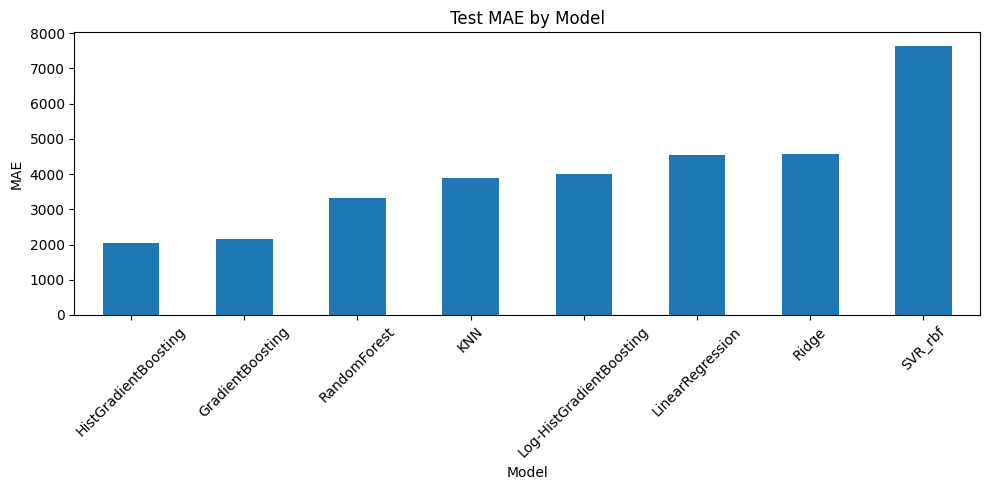

In [ ]:
import matplotlib.pyplot as plt

ax = metrics_df.sort_values("MAE").plot(kind="bar", x="Model", y="MAE", legend=False, figsize=(10,5), rot=45)
plt.title("Test MAE by Model")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


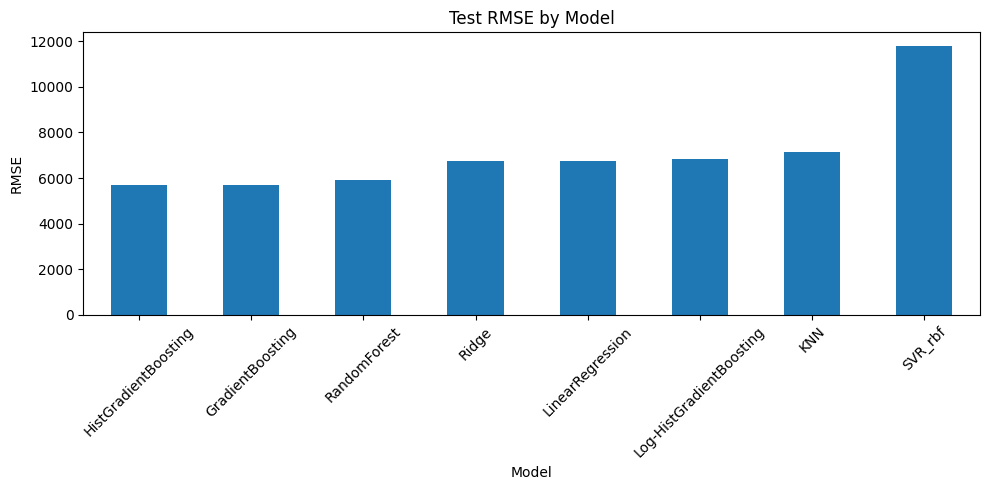

In [ ]:
import matplotlib.pyplot as plt

ax = metrics_df.sort_values("RMSE").plot(kind="bar", x="Model", y="RMSE", legend=False, figsize=(10,5), rot=45)
plt.title("Test RMSE by Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


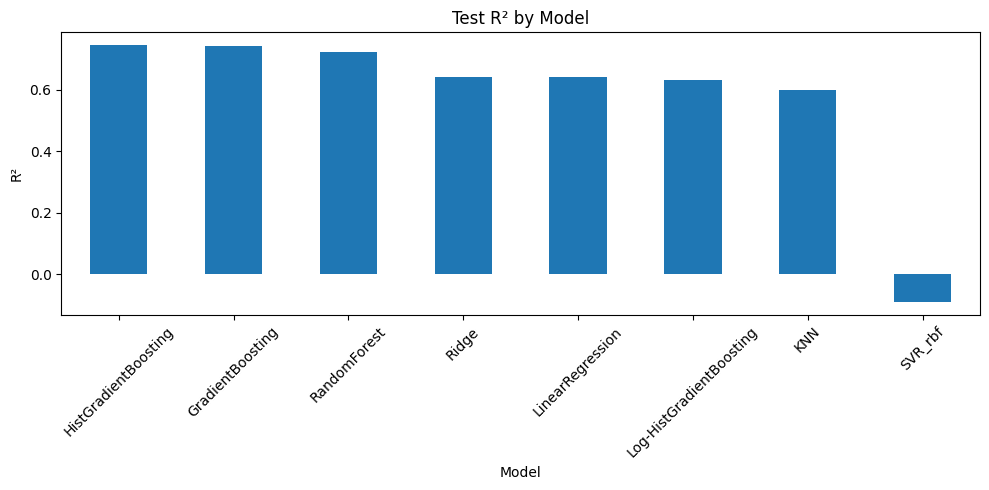

In [ ]:
ax = metrics_df.sort_values("R2", ascending=False).plot(kind="bar", x="Model", y="R2", legend=False, figsize=(10,5), rot=45)
plt.title("Test R² by Model")
plt.ylabel("R²")
plt.tight_layout()
plt.show()


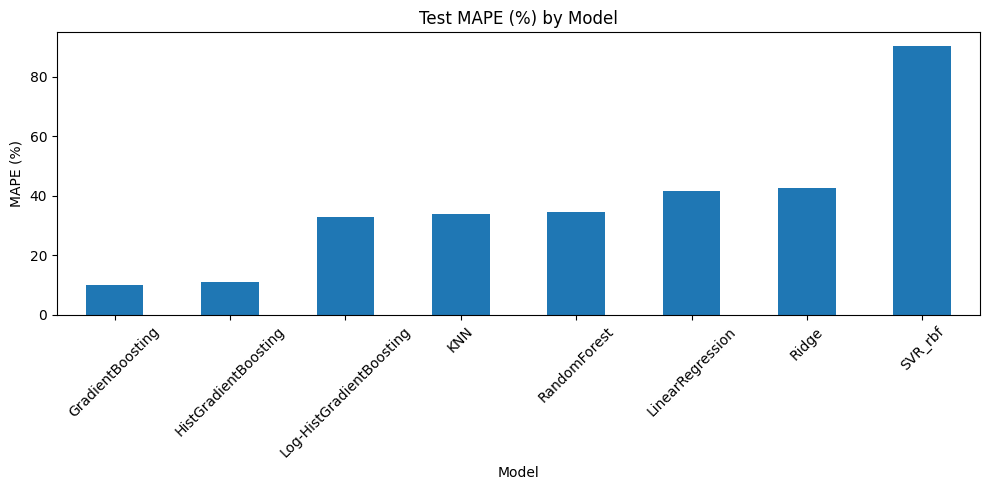

In [ ]:
ax = metrics_df.sort_values("MAPE").plot(kind="bar", x="Model", y="MAPE", legend=False, figsize=(10,5), rot=45)
plt.title("Test MAPE (%) by Model")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()

In [ ]:
rank_df = metrics_df.copy()

# Ranks: lower is better for these
for col in ["MAE","RMSE","MedAE","MAPE"]:
    rank_df[col+"_rank"] = rank_df[col].rank(method="min", ascending=True)

# R2: higher is better
rank_df["R2_rank"] = rank_df["R2"].rank(method="min", ascending=False)

# Composite: average of all ranks
rank_cols = ["MAE_rank","RMSE_rank","MedAE_rank","MAPE_rank","R2_rank"]
rank_df["CompositeRank"] = rank_df[rank_cols].mean(axis=1)

rank_df = rank_df.sort_values("CompositeRank").reset_index(drop=True)
rank_df_display = rank_df[["Model","CompositeRank","MAE","RMSE","R2","MedAE","MAPE"]]
rank_df_display


,Model,CompositeRank,MAE,RMSE,R2,MedAE,MAPE
0,HistGradientBoosting,1.4,2053.081611,5692.663043,0.746029,182.451457,10.984347
1,GradientBoosting,1.6,2152.164653,5709.584917,0.744517,137.041627,10.209859
2,RandomForest,3.4,3315.588773,5930.366573,0.724377,1313.432205,34.547613
3,Log-HistGradientBoosting,5.0,4013.435169,6842.890704,0.633029,1676.443372,33.005674
4,KNN,5.2,3899.279911,7141.662434,0.600284,1514.774869,33.775399
5,LinearRegression,5.6,4531.453110,6749.730067,0.642953,2412.457077,41.604674
6,Ridge,5.8,4567.344074,6749.491777,0.642978,2513.460791,42.460459
7,SVR_rbf,8.0,7642.522564,11801.117649,-0.091438,4612.250338,90.311976


In [ ]:
best_overall = rank_df.iloc[0]["Model"]
second_overall = rank_df.iloc[1]["Model"]

print("Best two by composite ranking:")
print(rank_df_display.head(2))

print("\nDeduction:")
print(f"1) {best_overall} — best blend of low MAE/RMSE/MedAE/MAPE and strong R².")
print(f"2) {second_overall} — consistently strong across metrics, close to the top.")


Best two by composite ranking:
                  Model  CompositeRank          MAE         RMSE        R2  \
0  HistGradientBoosting            1.4  2053.081611  5692.663043  0.746029   
1      GradientBoosting            1.6  2152.164653  5709.584917  0.744517   

        MedAE       MAPE  
0  182.451457  10.984347  
1  137.041627  10.209859  

Deduction:
1) HistGradientBoosting — best blend of low MAE/RMSE/MedAE/MAPE and strong R².
2) GradientBoosting — consistently strong across metrics, close to the top.


In [ ]:
top2 = metrics_df.nsmallest(2, "MAE").copy()
best_name = top2.iloc[0]["Model"]
second_name = top2.iloc[1]["Model"]
print("Top 2 by MAE:")
print(top2[["Model","MAE","RMSE","R2","MedAE","MAPE"]])


Top 2 by MAE:
                  Model          MAE         RMSE        R2       MedAE  \
0  HistGradientBoosting  2053.081611  5692.663043  0.746029  182.451457   
1      GradientBoosting  2152.164653  5709.584917  0.744517  137.041627   

        MAPE  
0  10.984347  
1  10.209859  


best one

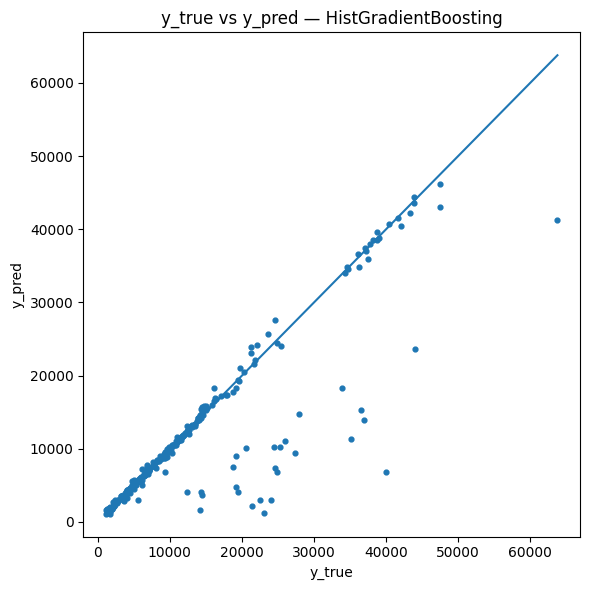

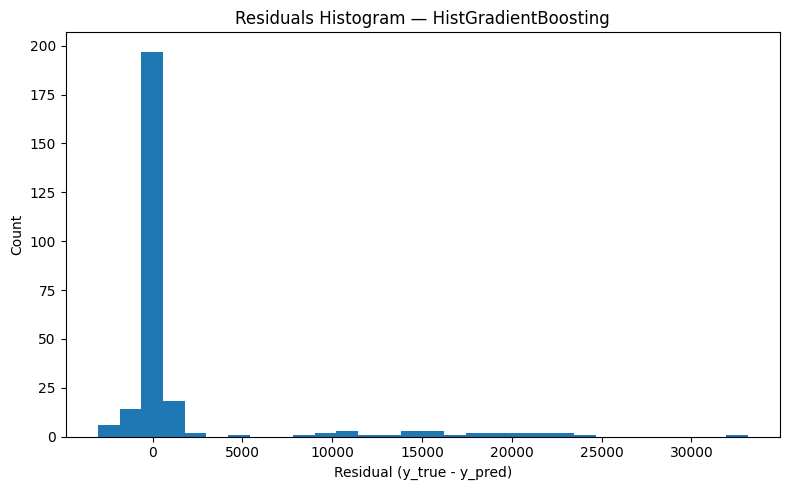

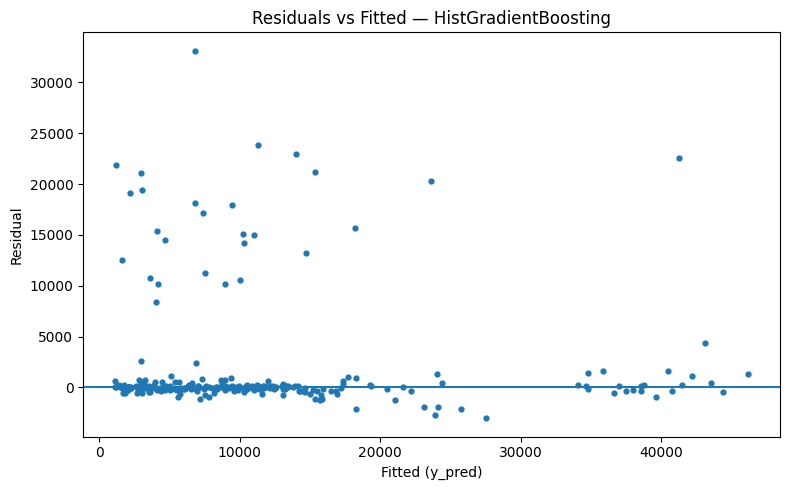

In [ ]:
import matplotlib.pyplot as plt
best_pred = pred_cache[best_name]
res_best = y_test - best_pred

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, s=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title(f"y_true vs y_pred — {best_name}")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.hist(res_best, bins=30)
plt.title(f"Residuals Histogram — {best_name}")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(best_pred, res_best, s=12)
plt.axhline(0)
plt.title(f"Residuals vs Fitted — {best_name}")
plt.xlabel("Fitted (y_pred)")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


second best

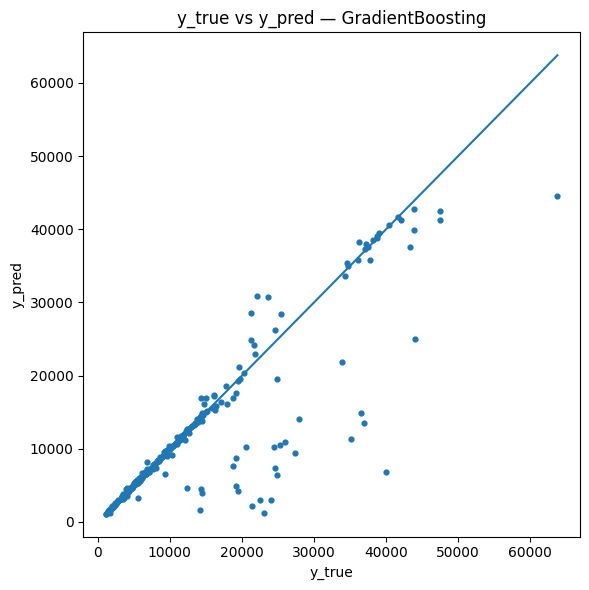

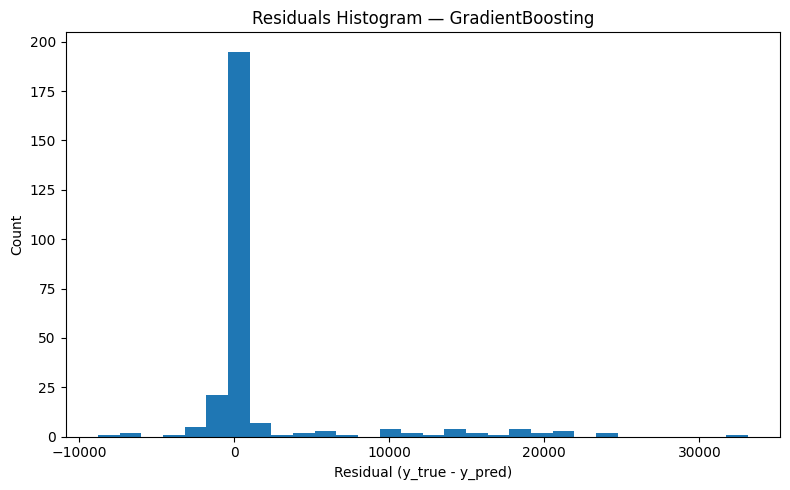

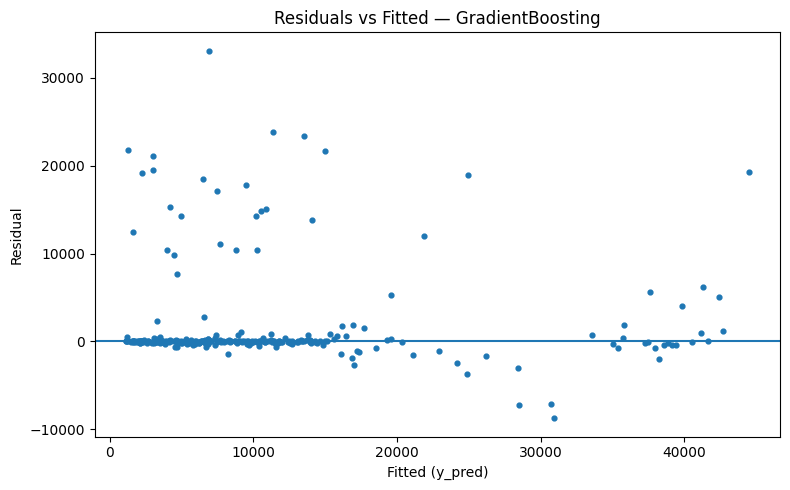

In [ ]:
import matplotlib.pyplot as plt
second_pred = pred_cache[second_name]
res_second = y_test - second_pred

plt.figure(figsize=(6,6))
plt.scatter(y_test, second_pred, s=12)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.title(f"y_true vs y_pred — {second_name}")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(res_second, bins=30)
plt.title(f"Residuals Histogram — {second_name}")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(second_pred, res_second, s=12)
plt.axhline(0)
plt.title(f"Residuals vs Fitted — {second_name}")
plt.xlabel("Fitted (y_pred)")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV, KFold
hgb_base = Pipeline([
    ("prep", preprocess_basic),
    ("est", HistGradientBoostingRegressor(
        loss="absolute_error",     # optimizes MAE
        random_state=42
    ))
])

gbr_base = Pipeline([
    ("prep", preprocess_basic),
    ("est", GradientBoostingRegressor(
        loss="absolute_error",
        random_state=42
    ))
])

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

# ---- HGB search space ----
hgb_param_dist = {
    "est__learning_rate": uniform(0.03, 0.12),
    "est__max_iter": [600, 900, 1200, 1500, 2000],
    "est__max_depth": [None, 3, 5, 7, 9],
    "est__min_samples_leaf": [5, 10, 20, 30, 50],
    "est__l2_regularization": loguniform(1e-5, 1e-1),
    "est__max_bins": [128, 255],
    "est__early_stopping": [True],
    "est__validation_fraction": [0.1, 0.15],
    "est__n_iter_no_change": [50, 100],
    "est__tol": [1e-7, 1e-5],
}

hgb_search = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=hgb_param_dist,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ---- GBR search space ----
gbr_param_dist = {
    "est__learning_rate": loguniform(1e-2, 2e-1),
    "est__n_estimators": [600, 900, 1200, 1600, 2000],
    "est__max_depth": [2, 3, 4, 5],
    "est__subsample": [0.6, 0.8, 0.9, 1.0],
    "est__min_samples_leaf": [1, 3, 5, 10, 20],
    "est__min_samples_split": [2, 5, 10, 20],
    "est__max_features": ["sqrt", "log2", None, 0.6, 0.8, 1.0],
    "est__loss": ["absolute_error", "huber"],
    "est__alpha": [0.85, 0.9, 0.95],
    "est__validation_fraction": [0.1, 0.15],
    "est__n_iter_no_change": [20, 40],
    "est__tol": [1e-4, 1e-3],
}

gbr_search = RandomizedSearchCV(
    estimator=gbr_base,
    param_distributions=gbr_param_dist,
    n_iter=40,
    scoring="neg_mean_absolute_error",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [ ]:
hgb_search.fit(X_train, y_train)
gbr_search.fit(X_train, y_train)

print("Best HGB CV MAE:", -hgb_search.best_score_)
print("Best HGB params:", hgb_search.best_params_)

print("\nBest GBR CV MAE:", -gbr_search.best_score_)
print("Best GBR params:", gbr_search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best HGB CV MAE: 2128.6957574003
Best HGB params: {'est__early_stopping': True, 'est__l2_regularization': np.float64(0.006070874110546389), 'est__learning_rate': np.float64(0.13300305657764638), 'est__max_bins': 255, 'est__max_depth': 5, 'est__max_iter': 1500, 'est__min_samples_leaf': 20, 'est__n_iter_no_change': 100, 'est__tol': 1e-07, 'est__validation_fraction': 0.1}

Best GBR CV MAE: 2062.0798844128785
Best GBR params: {'est__alpha': 0.85, 'est__learning_rate': np.float64(0.06358606736176979), 'est__loss': 'huber', 'est__max_depth': 3, 'est__max_features': 0.8, 'est__min_samples_leaf': 10, 'est__min_samples_split': 2, 'est__n_estimators': 600, 'est__n_iter_no_change': 20, 'est__subsample': 0.9, 'est__tol': 0.0001, 'est__validation_fraction': 0.15}


In [ ]:
prev_hgb = models["HistGradientBoosting"]
prev_gbr = models["GradientBoosting"]

hgb_tuned = hgb_search.best_estimator_
gbr_tuned = gbr_search.best_estimator_

def full_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2   = r2_score(y_true, y_pred)
    medae= median_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100.0
    return dict(MAE=mae, RMSE=rmse, R2=r2, MedAE=medae, MAPE=mape)
eval_rows = []
for label, mdl in [
    ("HGB_prev", prev_hgb),
    ("HGB_tuned", hgb_tuned),
    ("GBR_prev", prev_gbr),
    ("GBR_tuned", gbr_tuned),
]:
    yp = mdl.predict(X_test)
    m  = full_metrics(y_test, yp)
    m.update(Model=label)
    eval_rows.append(m)

tuned_df = pd.DataFrame(eval_rows).sort_values("MAE").reset_index(drop=True)
tuned_df


In [ ]:
from copy import deepcopy

iters = [100, 200, 400, 600, 800, 1000, 1200, 1500, 2000]
mae_curve = []

base = deepcopy(hgb_tuned)
for it in iters:
    step = deepcopy(base)
    step.set_params(est__max_iter=it)
    step.fit(X_train, y_train)
    pred = step.predict(X_test)
    mae_curve.append(mean_absolute_error(y_test, pred))

plt.figure(figsize=(7,5))
plt.plot(iters, mae_curve, marker="o")
plt.title("HGB Learning Curve (MAE vs max_iter)")
plt.xlabel("max_iter")
plt.ylabel("Test MAE")
plt.tight_layout()
plt.show()


In [ ]:
ests = [200, 400, 600, 800, 1000, 1200, 1600, 2000]
mae_curve = []

base = deepcopy(gbr_tuned)
for ne in ests:
    step = deepcopy(base)
    step.set_params(est__n_estimators=ne)
    step.fit(X_train, y_train)
    pred = step.predict(X_test)
    mae_curve.append(mean_absolute_error(y_test, pred))

plt.figure(figsize=(7,5))
plt.plot(ests, mae_curve, marker="o")
plt.title("GBR Learning Curve (MAE vs n_estimators)")
plt.xlabel("n_estimators")
plt.ylabel("Test MAE")
plt.tight_layout()
plt.show()

In [ ]:
try:
    feature_names = hgb_tuned.named_steps["prep"].get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(hgb_tuned.named_steps["prep"].transform(X_train[:1]).shape[1])])

def plot_importances(model, title):
    # Works for tree-based models exposing feature_importances_
    if hasattr(model.named_steps["est"], "feature_importances_"):
        imps = model.named_steps["est"].feature_importances_
        idx  = np.argsort(imps)[::-1][:20]
        names= feature_names[idx]
        vals = imps[idx]
        plt.figure(figsize=(8,6))
        plt.barh(range(len(vals)), vals[::-1])
        plt.yticks(range(len(vals)), names[::-1])
        plt.title(title)
        plt.xlabel("Feature importance")
        plt.tight_layout()
        plt.show()
    else:
        print(title, "— no feature_importances_ available.")

plot_importances(hgb_tuned, "Tuned HGB — Top  Feature Importances")
plot_importances(gbr_tuned, "Tuned GBR — Top  Feature Importances")

In [ ]:
best_new_row = tuned_df.iloc[0]
best_new_name = best_new_row["Model"]
print("New best (tuned) candidate:", best_new_name)
print(best_new_row)

# Map to object
name_to_model = {
    "HGB_prev": prev_hgb,
    "HGB_tuned": hgb_tuned,
    "GBR_prev": prev_gbr,
    "GBR_tuned": gbr_tuned
}
final_tuned_model = name_to_model[best_new_name]


joblib.dump(final_tuned_model, "insurance_best_model_tuned.joblib")
tuned_df.to_csv("tuned_candidates_metrics.csv", index=False)

print("\nSaved:")
print(" - insurance_best_model_tuned.joblib")
print(" - tuned_candidates_metrics.csv")

**Modele 4:**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_encoded (3).csv to data_encoded (3).csv


In [ ]:
data = pd.read_csv("data_encoded (3).csv")

In [ ]:
def risk_category(charges):
    if charges < 5000:
        return "faible"
    elif charges < 10000:
        return "moyen"
    else:
        return "eleve"

In [ ]:
data["risk"] = data["charges"].apply(risk_category)
data= data[data["age"] <= 30]

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["risk_encoded"] = le.fit_transform(data["risk"])

In [ ]:
data

,age,bmi,children,region,charges,sex_male,smoker_yes,risk,risk_encoded
0,19.0,27.90,0.0,3,16884.92400,0,1,eleve,0
1,18.0,33.77,1.0,2,1725.55230,1,0,faible,1
2,28.0,33.00,3.0,2,4449.46200,1,0,faible,1
10,25.0,26.22,0.0,0,2721.32080,1,0,faible,1
12,23.0,34.40,0.0,3,1826.84300,1,0,faible,1
...,...,...,...,...,...,...,...,...,...
1304,18.0,53.13,0.0,2,1163.46270,1,0,faible,1
1318,23.0,33.40,0.0,3,10795.93733,0,0,eleve,0
1321,18.0,31.92,0.0,0,2205.98080,0,0,faible,1
1322,18.0,36.85,0.0,2,1629.83350,0,0,faible,1


In [ ]:
X = data.drop(columns=["charges", "risk", "risk_encoded"])
y = data["risk_encoded"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.86      0.97      0.91        58
           2       0.00      0.00      0.00         4

    accuracy                           0.87        87
   macro avg       0.59      0.59      0.59        87
weighted avg       0.84      0.87      0.85        87



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


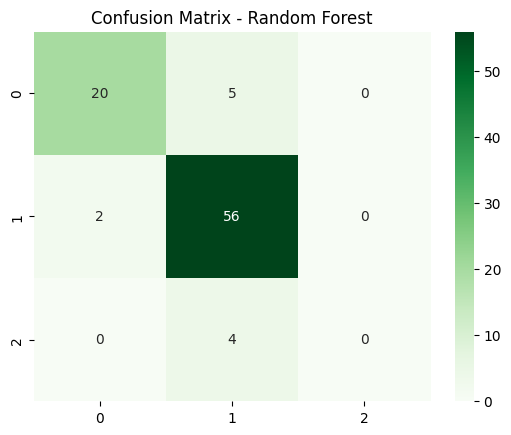

In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Meilleurs paramètres Random Forest :", grid_rf.best_params_)

y_pred_rf = grid_rf.predict(X_test)

Meilleurs paramètres Random Forest : {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        25
           1       0.88      0.98      0.93        58
           2       0.50      0.25      0.33         4

    accuracy                           0.90        87
   macro avg       0.79      0.68      0.72        87
weighted avg       0.89      0.90      0.89        87



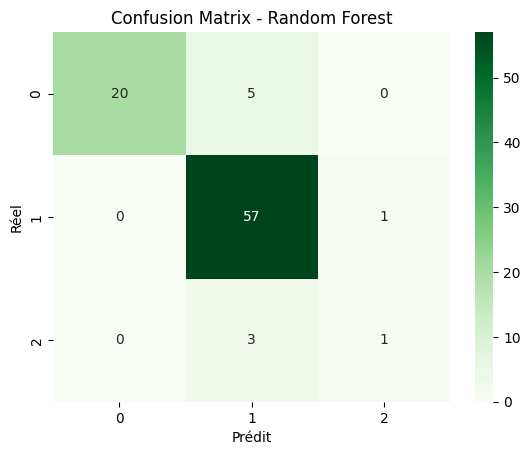

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_params_rf = {
    'class_weight': 'balanced',
    'max_depth': 5,
    'min_samples_split': 5,
    'n_estimators': 100,
    'random_state': 42
}

rf_best = RandomForestClassifier(**best_params_rf)
rf_best.fit(X_train, y_train)

y_pred_rf = rf_best.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


In [ ]:
new_data = pd.DataFrame({
    'age': [19, 18, 28, 25],
    'bmi': [27.90, 33.77, 33.00, 26.22],
    'children': [0, 1, 3, 0],
    'region': [3, 2, 2, 0],
    'sex_male': [0, 1, 1, 1],
    'smoker_yes': [1, 0, 0, 0]
})

In [ ]:
new_data_scaled = scaler.transform(new_data)
y_pred_rf = rf_best.predict(new_data_scaled)

messages = {
    0: "le jeune assuré a un risque élevé",
    1: "le jeune assuré a un risque faible",
    2: "le jeune assuré a un risque moyen"
}

for i, pred in enumerate(y_pred_rf):
    print(f"Exemple {i+1} → {messages[pred]}")



Exemple 1 → le jeune assuré a un risque élevé
Exemple 2 → le jeune assuré a un risque faible
Exemple 3 → le jeune assuré a un risque faible
Exemple 4 → le jeune assuré a un risque faible


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Model 5
 **ocsvm et isoforest**

  Identifier les assurés « atypiques »


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Fixer une graine aléatoire
RANDOM_STATE = 42
test=pd.read_csv("dataAssurance.csv")

In [2]:
dff = pd.read_csv("dataAssurance.csv")

In [3]:
print("=== Dimensions du dataset ===")
print(f"Lignes : {dff.shape[0]}, Colonnes : {dff.shape[1]}")

=== Dimensions du dataset ===
Lignes : 1443, Colonnes : 7


In [4]:
# Aperçu des premières lignes
print("Aperçu du dataset :")
display(dff.head())

Aperçu du dataset :


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [5]:
# Informations générales
print("\nInformations générales :")
print(dff.info())


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1406 non-null   float64
 1   sex       1405 non-null   object 
 2   bmi       1410 non-null   float64
 3   children  1414 non-null   float64
 4   smoker    1417 non-null   object 
 5   region    1410 non-null   object 
 6   charges   1414 non-null   float64
dtypes: float64(4), object(3)
memory usage: 79.0+ KB
None


In [6]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
display(dff.describe(include="all"))


Statistiques descriptives :


,age,sex,bmi,children,smoker,region,charges
count,1406.000000,1405,1410.000000,1414.000000,1417,1410,1414.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,719,NaN,NaN,1132,381,NaN
mean,39.179232,NaN,30.637681,1.086280,NaN,NaN,13179.307173
std,14.067120,NaN,6.112450,1.196088,NaN,NaN,11987.371506
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,26.000000,NaN,26.220000,0.000000,NaN,NaN,4748.057175
50%,39.000000,NaN,30.302500,1.000000,NaN,NaN,9369.615750
75%,51.000000,NaN,34.656250,2.000000,NaN,NaN,16547.261588


In [7]:
# 2. Statistiques descriptives
print("\n=== Statistiques descriptives ===")
display(dff.describe(include="all").T)


=== Statistiques descriptives ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1406.0,NaN,NaN,NaN,39.179232,14.06712,18.0,26.0,39.0,51.0,64.0
sex,1405,2,male,719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1410.0,NaN,NaN,NaN,30.637681,6.11245,15.96,26.22,30.3025,34.65625,53.13
children,1414.0,NaN,NaN,NaN,1.08628,1.196088,0.0,0.0,1.0,2.0,5.0
smoker,1417,2,no,1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1410,4,southeast,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1414.0,NaN,NaN,NaN,13179.307173,11987.371506,1121.8739,4748.057175,9369.61575,16547.261588,63770.42801


In [8]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(dff.isna().sum())


Valeurs manquantes par colonne :
age         37
sex         38
bmi         33
children    29
smoker      26
region      33
charges     29
dtype: int64


In [10]:
# 1. Suppression des doublons
print("Taille avant suppression des doublons :", dff.shape)
dff = dff.drop_duplicates()
print("Taille après suppression des doublons :", dff.shape)

Taille avant suppression des doublons : (1443, 7)
Taille après suppression des doublons : (1338, 7)


In [13]:
# 2. Gestion des valeurs manquantes
# Ici, on peut choisir de supprimer ou d’imputer.
dff = dff.fillna(dff.mean(numeric_only=True))

In [18]:
 4.#Dédtection des outliers via les IQR (interquartiles)
 numeric_cols = dff.select_dtypes(include=np.number).columns
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return outliers, lower, upper

for col in numeric_cols:
    outliers, low, up = detect_outliers_iqr(dff[col])
    print(f"\nColonne : {col}")
    print(f" - Q1 = {dff[col].quantile(0.25):.2f}")
    print(f" - Q3 = {dff[col].quantile(0.75):.2f}")
    print(f" - IQR = {dff[col].quantile(0.75) - dff[col].quantile(0.25):.2f}")
    print(f" - Limite basse = {low:.2f}, Limite haute = {up:.2f}")
    print(f" - Nb outliers détectés : {len(outliers)}")


Colonne : age
 - Q1 = 27.00
 - Q3 = 51.00
 - IQR = 24.00
 - Limite basse = -9.00, Limite haute = 87.00
 - Nb outliers détectés : 0

Colonne : bmi
 - Q1 = 26.40
 - Q3 = 34.43
 - IQR = 8.03
 - Limite basse = 14.35, Limite haute = 46.48
 - Nb outliers détectés : 14

Colonne : children
 - Q1 = 0.00
 - Q3 = 2.00
 - IQR = 2.00
 - Limite basse = -3.00, Limite haute = 5.00
 - Nb outliers détectés : 0

Colonne : charges
 - Q1 = 4828.59
 - Q3 = 16132.90
 - IQR = 11304.31
 - Limite basse = -12127.88, Limite haute = 33089.36
 - Nb outliers détectés : 147


In [19]:
# 4. Création de deux jeux de variables :
# - FS_A : profil démographique et style de vie (sans charges)
# - FS_B : FS_A + variable charges

fs_a_features = ["age", "bmi", "children", "sex", "smoker", "region"]
fs_b_features = fs_a_features + ["charges"]


In [21]:
# Séparation numérique et catégorielle
def split_feature_types(columns, frame):
    num = [c for c in columns if np.issubdtype(frame[c].dtype, np.number)]
    cat = [c for c in columns if c not in num]
    return num, cat

num_a, cat_a = split_feature_types(fs_a_features, dff)
num_b, cat_b = split_feature_types(fs_b_features, dff)

In [22]:
# Préprocesseur pour FS_A
preprocess_a = ColumnTransformer([
    ("num", StandardScaler(), num_a),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_a),
])

# Préprocesseur pour FS_B
preprocess_b = ColumnTransformer([
    ("num", StandardScaler(), num_b),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_b),
])

In [23]:
# Données d’entrée
X_a = dff[fs_a_features]
X_b = dff[fs_b_features]

# 1. Pipelines Isolation Forest
isoforest_a = Pipeline([
    ("prep", preprocess_a),
    ("model", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

isoforest_b = Pipeline([
    ("prep", preprocess_b),
    ("model", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# 2. Pipelines One-Class SVM (avec tuning léger + novelty)
from sklearn.svm import OneClassSVM

TARGET_OUTLIER_RATE = 0.05

ocsvm_a = Pipeline([
    ("prep", preprocess_a),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=TARGET_OUTLIER_RATE))
])
ocsvm_b = Pipeline([
    ("prep", preprocess_b),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=TARGET_OUTLIER_RATE))
])


# 3. Entraînement des modèles
print("Entraînement des modèles en cours...")

isoforest_a.fit(X_a)
isoforest_b.fit(X_b)

# OCSVM is trained on normal data only in novelty detection, but here we fit on all data
# as per the evaluation logic.
ocsvm_a.fit(X_a)
ocsvm_b.fit(X_b)

print("✅ Modèles entraînés avec succès (CRISP-DM jusqu'à Modélisation).")

# Sauvegarde des modèles (optionnel)
joblib.dump(isoforest_a, "isoforest_FS_A.joblib")
joblib.dump(isoforest_b, "isoforest_FS_B.joblib")
joblib.dump(ocsvm_a, "ocsvm_FS_A.joblib")
joblib.dump(ocsvm_b, "ocsvm_FS_B.joblib")

Entraînement des modèles en cours...
✅ Modèles entraînés avec succès (CRISP-DM jusqu'à Modélisation).


['ocsvm_FS_B.joblib']

In [25]:
# ================================
# ÉVALUATION GÉNÉRIQUE TOUS MODÈLES (version stable)
# ================================
import numpy as np
import pandas as pd

# 0) Prépare les jeux de features (adaptés à tes préprocess)
X_map = {
    "IF_A": X_a,
    "IF_B": X_b,
    "OCSVM_A": X_a,
    "OCSVM_B": X_b,
}

# 1) Regroupe les pipelines
models = {
    "IF_A": isoforest_a,
    "IF_B": isoforest_b,
    "OCSVM_A": ocsvm_a,
    "OCSVM_B": ocsvm_b,
}

# Paramètre métier
try:
    TARGET_OUTLIER_RATE
except NameError:
    TARGET_OUTLIER_RATE = 0.05  # 5% par défaut

# 2) Copie du DF résultats
df_results = dff.copy()
# 2-bis) Utilitaire: transforme scores → prédictions
def anomaly_from_scores(scores, rate=-1):
    if rate == -1:
        # Cas spécial : aucune anomalie (tout normal)
        return np.zeros_like(scores, dtype=int)
    else:
        # Seuil = quantile haut (ex: 95% si rate=0.05 → top 5% anomalies)
        threshold = np.quantile(scores, 1 - rate)
        return (scores >= threshold).astype(int)  # 1 = anomalie, 0 = normal
# 3) Calcul des scores + prédictions
for name, model in models.items():
    X = X_map[name]

    # On applique explicitement le preprocessing entraîné (imputation + OHE + scaling)
    Z = model.named_steps["prep"].transform(X)
    algo = model.named_steps["model"]

    # --- Calcul des scores bruts selon l'algo ---
    if name.startswith("IF"):
        raw_score = algo.score_samples(Z)        # grand = normal
    else:
        raw_score = algo.decision_function(Z)    # grand = normal

    # --- Uniformisation : grand = anormal ---
    anomaly_score = -raw_score

    # --- Seuil métier par quantile ---
    preds_bin = anomaly_from_scores(anomaly_score, rate=TARGET_OUTLIER_RATE)  # 1 = anomalie, 0 = normal
    preds_pm1 = np.where(preds_bin == 1, -1, 1)  # compatibilité sklearn (-1=anom, +1=normal)

    # Stockage
    df_results[f"{name}_score"] = anomaly_score
    df_results[f"{name}_pred_bin"] = preds_bin
    df_results[f"{name}_pred"] = preds_pm1
# 4) Compter les anomalies par modèle
print("=== Nombre d’anomalies détectées (par modèle) ===")
for name in models.keys():
    n_anom = int(df_results[f"{name}_pred_bin"].sum())
    rate = df_results[f"{name}_pred_bin"].mean() * 100
    print(f"{name:10s}: {n_anom}  ({rate:.2f} %)")
    # 5) Tableau récap
summary = []
for name in models.keys():
    summary.append({
        "model": name,
        "n_rows": len(df_results),
        "n_anomalies": int(df_results[f"{name}_pred_bin"].sum()),
        "anomaly_rate_%": 100 * df_results[f"{name}_pred_bin"].mean()
    })
summary_df = pd.DataFrame(summary).sort_values("model")
display(summary_df)

# ================================
# SANITY CHECKS
# ================================

print("\n=== Contrôle du taux d'anomalies ===")
tol = 0.02
for name in models.keys():
    rate_obs = float(df_results[f"{name}_pred_bin"].mean())
    delta = rate_obs - TARGET_OUTLIER_RATE
    status = "OK" if abs(delta) <= tol else "⚠️"
    print(f"{name:10s} -> obs={rate_obs:.3f}  cible={TARGET_OUTLIER_RATE:.3f}  Δ={delta:+.3f}  {status}")

print("\n=== Cohérence des scores (grand = anormal) ===")
for name, model in models.items():
    X = X_map[name]
    Z = model.named_steps["prep"].transform(X)
    algo = model.named_steps["model"]
    if name.startswith("IF"):
        raw = algo.score_samples(Z)
    else:
        raw = algo.decision_function(Z)
    anomaly_score = df_results[f"{name}_score"].to_numpy()
    corr = np.corrcoef(anomaly_score, -raw)[0,1]
    status = "OK" if corr > 0.95 else ("⚠️" if corr > 0.8 else "❗")
    print(f"{name:10s} corr(score, -raw): {corr:.3f} {status}")

print("\n=== Consensus IF vs OCSVM ===")
def consensus_report(prefix_if, prefix_svm):
    a = df_results[f"{prefix_if}_pred_bin"].to_numpy()
    b = df_results[f"{prefix_svm}_pred_bin"].to_numpy()
    agree = (a == b).mean()
    both_anom = ((a == 1) & (b == 1)).mean()
    print(f"{prefix_if} vs {prefix_svm} -> Accord global: {agree*100:.2f}% | Anomalies communes: {both_anom*100:.2f}%")

consensus_report("IF_A", "OCSVM_A")
consensus_report("IF_B", "OCSVM_B")

# 6) Top-K à auditer
K = 10
for name in models.keys():
    print(f"\n=== Top {K} anomalies à auditer ({name}) ===")
    cols_show = ["age","bmi","children","smoker","charges", f"{name}_score"]
    ex = (
        df_results
        .loc[df_results[f"{name}_pred_bin"] == 1]
        .sort_values(f"{name}_score", ascending=False)
        .head(K)
    )
    display(ex[cols_show] if all(c in ex.columns for c in cols_show) else ex.head(K))


=== Nombre d’anomalies détectées (par modèle) ===
IF_A      : 67  (5.01 %)
IF_B      : 67  (5.01 %)
OCSVM_A   : 67  (5.01 %)
OCSVM_B   : 67  (5.01 %)


,model,n_rows,n_anomalies,anomaly_rate_%
0,IF_A,1338,67,5.007474
1,IF_B,1338,67,5.007474
2,OCSVM_A,1338,67,5.007474
3,OCSVM_B,1338,67,5.007474



=== Contrôle du taux d'anomalies ===
IF_A       -> obs=0.050  cible=0.050  Δ=+0.000  OK
IF_B       -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_A    -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_B    -> obs=0.050  cible=0.050  Δ=+0.000  OK

=== Cohérence des scores (grand = anormal) ===
IF_A       corr(score, -raw): 1.000 OK
IF_B       corr(score, -raw): 1.000 OK
OCSVM_A    corr(score, -raw): 1.000 OK
OCSVM_B    corr(score, -raw): 1.000 OK

=== Consensus IF vs OCSVM ===
IF_A vs OCSVM_A -> Accord global: 92.68% | Anomalies communes: 1.35%
IF_B vs OCSVM_B -> Accord global: 93.72% | Anomalies communes: 1.87%

=== Top 10 anomalies à auditer (IF_A) ===


,age,bmi,children,smoker,charges,IF_A_score
1131,27.0,45.90000,2.0,NaN,3693.42800,0.682917
837,56.0,28.31000,0.0,NaN,11657.71890,0.679827
1031,55.0,35.20000,0.0,NaN,44423.80300,0.679628
545,49.0,25.84000,2.0,NaN,23807.24060,0.677991
747,19.0,21.75500,0.0,no,1627.28245,0.658619
1288,20.0,39.40000,2.0,yes,38344.56600,0.656355
773,19.0,28.88000,0.0,yes,17748.50620,0.641138
857,25.0,24.13000,0.0,yes,15817.98570,0.637895
912,59.0,30.66938,3.0,NaN,14382.70905,0.637213
1232,54.0,24.60500,3.0,NaN,12479.70895,0.635852



=== Top 10 anomalies à auditer (IF_B) ===


,age,bmi,children,smoker,charges,IF_B_score
1031,55.0,35.200,0.0,NaN,44423.80300,0.685236
545,49.0,25.840,2.0,NaN,23807.24060,0.675677
837,56.0,28.310,0.0,NaN,11657.71890,0.675002
1131,27.0,45.900,2.0,NaN,3693.42800,0.672738
558,35.0,34.105,3.0,NaN,39983.42595,0.644096
747,19.0,21.755,0.0,no,1627.28245,0.642388
1288,20.0,39.400,2.0,yes,38344.56600,0.641497
773,19.0,28.880,0.0,yes,17748.50620,0.637901
857,25.0,24.130,0.0,yes,15817.98570,0.637225
420,64.0,33.880,0.0,NaN,46889.26120,0.637064



=== Top 10 anomalies à auditer (OCSVM_A) ===


,age,bmi,children,smoker,charges,OCSVM_A_score
438,52.0,46.75,5.0,no,12592.5345,2.690468
1085,39.0,18.30,5.0,yes,19023.2600,1.972807
1317,18.0,53.13,0.0,no,1163.4627,1.807521
640,33.0,42.40,5.0,no,6666.2430,1.450981
1047,22.0,52.58,1.0,yes,44501.3982,1.131434
166,20.0,37.00,5.0,no,4830.6300,0.968155
116,58.0,49.06,0.0,no,11381.3254,0.924564
1131,27.0,45.90,2.0,NaN,3693.4280,0.846518
172,18.0,15.96,0.0,no,1694.7964,0.623680
250,18.0,17.29,2.0,yes,12829.4551,0.535532



=== Top 10 anomalies à auditer (OCSVM_B) ===


,age,bmi,children,smoker,charges,OCSVM_B_score
438,52.000000,46.750,5.0,no,12592.53450,2.224585
543,39.207055,47.410,0.0,yes,63770.42801,2.035707
1317,18.000000,53.130,0.0,no,1163.46270,1.851504
1047,22.000000,52.580,1.0,yes,44501.39820,1.825512
1085,39.000000,18.300,5.0,yes,19023.26000,1.728194
1300,45.000000,30.360,0.0,yes,62592.87309,1.501772
640,33.000000,42.400,5.0,no,6666.24300,0.972775
1131,27.000000,45.900,2.0,NaN,3693.42800,0.972566
1012,61.000000,33.330,4.0,no,36580.28216,0.867758
1230,52.000000,34.485,3.0,yes,60021.39897,0.831209


In [26]:
# ================================
# SANITY CHECKS (taux, cohérence, consensus)
# À placer juste après la cellule d'évaluation
# ================================
import numpy as np
import pandas as pd

# 1) Vérifier que le taux d'anomalies observé ~ TARGET_OUTLIER_RATE
print("=== Contrôle du taux d'anomalies (binaire 1=anomalie) ===")
tol = 0.02  # tolérance absolue de ±2 points
for name in models.keys():
    rate_obs = float(df_results[f"{name}_pred_bin"].mean())
    delta = rate_obs - TARGET_OUTLIER_RATE
    status = "OK" if abs(delta) <= tol else "⚠️"
    print(f"{name:10s} -> obs={rate_obs:.3f}  cible={TARGET_OUTLIER_RATE:.3f}  Δ={delta:+.3f}  {status}")
print()

# 2) Sanity: cohérence signe/échelle des scores (plus GRAND = + anormal)
#    On attend corr(score_anormal, -raw_score_normal) > 0
print("=== Cohérence des scores (grand = + anormal) ===")
for name, model in models.items():
    X = X_map[name]
    Z = model.named_steps["prep"].transform(X)
    if name.startswith("IF"):
        raw = model.named_steps["model"].score_samples(Z)  # grand = normal
    else:
        raw = model.named_steps["model"].decision_function(Z)  # grand = normal
    anomaly_score = df_results[f"{name}_score"].to_numpy()   # grand = anormal (déjà inversé dans l'éval)
    corr = np.corrcoef(anomaly_score, -raw)[0,1]
    status = "OK" if corr > 0.95 else ("⚠️" if corr > 0.8 else "❗")
    print(f"{name:10s} corr(score, -raw): {corr:.3f} {status}")
print()

# 3) Consensus IF vs OCSVM (même espace de features : A et B)
def consensus_report(prefix_if, prefix_svm):
    a = df_results[f"{prefix_if}_pred_bin"].to_numpy()
    b = df_results[f"{prefix_svm}_pred_bin"].to_numpy()
    agree = (a == b).mean()
    both_anom = ((a == 1) & (b == 1)).mean()
    print(f"Consensus {prefix_if} vs {prefix_svm} -> Accord global: {agree*100:.2f}%  |  'Anomalies communes': {both_anom*100:.2f}%")

print("=== Consensus IF vs OCSVM ===")
consensus_report("IF_A", "OCSVM_A")
consensus_report("IF_B", "OCSVM_B")
print()

# 4) Règles métier: vérifier corrélation simple avec flags (si présents)
rule_cols = [c for c in df_results.columns if c.startswith("rule_")]
if rule_cols:
    print("=== Corrélation (point-biserial approx.) entre règles métier et scores ===")
    for name in models.keys():
        s = df_results[f"{name}_score"].to_numpy()
        for rc in rule_cols:
            r = np.corrcoef(s, df_results[rc].to_numpy())[0,1]
            print(f"{name:10s} ~ {rc:28s} : corr={r:.3f}")
    print()

# 5) Top-K à auditer (par modèle) — échantillon actionnable
K = 10
for name in models.keys():
    print(f"\n=== Top {K} anomalies à auditer ({name}) ===")
    cols_show = ["age","bmi","children","smoker","charges", f"{name}_score"]
    cols_show += [c for c in rule_cols]  # ajoute les règles si dispo
    ex = (
        df_results
        .loc[df_results[f"{name}_pred_bin"] == 1]
        .sort_values(f"{name}_score", ascending=False)
        .head(K)
    )
    display(ex[cols_show] if all(c in ex.columns for c in cols_show) else ex.head(K))


=== Contrôle du taux d'anomalies (binaire 1=anomalie) ===
IF_A       -> obs=0.050  cible=0.050  Δ=+0.000  OK
IF_B       -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_A    -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_B    -> obs=0.050  cible=0.050  Δ=+0.000  OK

=== Cohérence des scores (grand = + anormal) ===
IF_A       corr(score, -raw): 1.000 OK
IF_B       corr(score, -raw): 1.000 OK
OCSVM_A    corr(score, -raw): 1.000 OK
OCSVM_B    corr(score, -raw): 1.000 OK

=== Consensus IF vs OCSVM ===
Consensus IF_A vs OCSVM_A -> Accord global: 92.68%  |  'Anomalies communes': 1.35%
Consensus IF_B vs OCSVM_B -> Accord global: 93.72%  |  'Anomalies communes': 1.87%


=== Top 10 anomalies à auditer (IF_A) ===


,age,bmi,children,smoker,charges,IF_A_score
1131,27.0,45.90000,2.0,NaN,3693.42800,0.682917
837,56.0,28.31000,0.0,NaN,11657.71890,0.679827
1031,55.0,35.20000,0.0,NaN,44423.80300,0.679628
545,49.0,25.84000,2.0,NaN,23807.24060,0.677991
747,19.0,21.75500,0.0,no,1627.28245,0.658619
1288,20.0,39.40000,2.0,yes,38344.56600,0.656355
773,19.0,28.88000,0.0,yes,17748.50620,0.641138
857,25.0,24.13000,0.0,yes,15817.98570,0.637895
912,59.0,30.66938,3.0,NaN,14382.70905,0.637213
1232,54.0,24.60500,3.0,NaN,12479.70895,0.635852



=== Top 10 anomalies à auditer (IF_B) ===


,age,bmi,children,smoker,charges,IF_B_score
1031,55.0,35.200,0.0,NaN,44423.80300,0.685236
545,49.0,25.840,2.0,NaN,23807.24060,0.675677
837,56.0,28.310,0.0,NaN,11657.71890,0.675002
1131,27.0,45.900,2.0,NaN,3693.42800,0.672738
558,35.0,34.105,3.0,NaN,39983.42595,0.644096
747,19.0,21.755,0.0,no,1627.28245,0.642388
1288,20.0,39.400,2.0,yes,38344.56600,0.641497
773,19.0,28.880,0.0,yes,17748.50620,0.637901
857,25.0,24.130,0.0,yes,15817.98570,0.637225
420,64.0,33.880,0.0,NaN,46889.26120,0.637064



=== Top 10 anomalies à auditer (OCSVM_A) ===


,age,bmi,children,smoker,charges,OCSVM_A_score
438,52.0,46.75,5.0,no,12592.5345,2.690468
1085,39.0,18.30,5.0,yes,19023.2600,1.972807
1317,18.0,53.13,0.0,no,1163.4627,1.807521
640,33.0,42.40,5.0,no,6666.2430,1.450981
1047,22.0,52.58,1.0,yes,44501.3982,1.131434
166,20.0,37.00,5.0,no,4830.6300,0.968155
116,58.0,49.06,0.0,no,11381.3254,0.924564
1131,27.0,45.90,2.0,NaN,3693.4280,0.846518
172,18.0,15.96,0.0,no,1694.7964,0.623680
250,18.0,17.29,2.0,yes,12829.4551,0.535532



=== Top 10 anomalies à auditer (OCSVM_B) ===


,age,bmi,children,smoker,charges,OCSVM_B_score
438,52.000000,46.750,5.0,no,12592.53450,2.224585
543,39.207055,47.410,0.0,yes,63770.42801,2.035707
1317,18.000000,53.130,0.0,no,1163.46270,1.851504
1047,22.000000,52.580,1.0,yes,44501.39820,1.825512
1085,39.000000,18.300,5.0,yes,19023.26000,1.728194
1300,45.000000,30.360,0.0,yes,62592.87309,1.501772
640,33.000000,42.400,5.0,no,6666.24300,0.972775
1131,27.000000,45.900,2.0,NaN,3693.42800,0.972566
1012,61.000000,33.330,4.0,no,36580.28216,0.867758
1230,52.000000,34.485,3.0,yes,60021.39897,0.831209


In [27]:
# =====================================================
# BLOC 6 : DASHBOARD INTERACTIF (PLOTLY)
# =====================================================
import plotly.express as px

# ⚠️ On part du DataFrame enrichi avec les colonnes anomalies (df_results)

# 1. Scatterplot interactif (BMI vs Charges)
fig1 = px.scatter(
    df_results,
    x="bmi", y="charges",
    color=(df_results["IF_A_pred"]==-1).map({True:"Anomalie", False:"Normal"}),
    hover_data=["age", "sex", "smoker", "region", "children"],
    title="Détection d’anomalies (Isolation Forest, FS_A)",
    color_discrete_map={"Normal":"green", "Anomalie":"red"}
)
fig1.show()

# 2. Barplot interactif : anomalies par région
df_results["anomaly_flag"] = (df_results["IF_A_pred"]==-1).map({True:"Anomalie", False:"Normal"})
fig2 = px.histogram(
    df_results,
    x="region", color="anomaly_flag",
    barmode="group",
    title="Nombre d’anomalies par région"
)
fig2.show()

# 3. Barplot interactif : anomalies par sexe
fig3 = px.histogram(
    df_results,
    x="sex", color="anomaly_flag",
    barmode="group",
    title="Nombre d’anomalies par sexe"
)
fig3.show()


In [28]:
# ============================================================
# CELLULE TEST : appliquer IF/OCSVM sur un exemple d’assuré
# (à placer APRÈS l’entraînement des pipelines isoforest_a/b et ocsvm_a/b)
# ============================================================

import pandas as pd

# 1) Définir un exemple d’assuré (adapte librement les valeurs)
example = {
    "age": 25,            # numérique
    "bmi": 40.0,          # numérique
    "children": 4,        # numérique
    "sex": "female",      # catégorielle
    "smoker": "nos",       # catégorielle ("yes"/"no" selon ton dataset)
    "region": "southeast",# catégorielle (par ex.: northeast/southeast/southwest/northwest)
    "charges": 40000.0    # numérique (UTILISÉ uniquement par FS_B)
}

# 2) Construire les DataFrames d’entrée dans l’ordre des features
#    - FS_A = profil sans "charges" -> fs_a_features
#    - FS_B = FS_A + "charges"      -> fs_b_features
x_a = pd.DataFrame([example])[fs_a_features]
x_b = pd.DataFrame([example])[fs_b_features]

# 3) Prédictions et scores pour chaque pipeline
#    Rappel: .predict(...) renvoie +1 (normal) ou -1 (anomalie)
#    decision_function(...) : plus négatif => plus atypique
res = {}

# --- Isolation Forest (FS_A) ---
pred_if_a = isoforest_a.predict(x_a)[0]
# decision_function est centré: >0 normal, <0 anomalie (plus négatif => plus anormal)
score_if_a = isoforest_a.named_steps["model"].decision_function(
    isoforest_a.named_steps["prep"].transform(x_a)
)[0]
res["IF_A"] = {"pred": int(pred_if_a), "decision_function": float(score_if_a)}

# --- Isolation Forest (FS_B) ---
pred_if_b = isoforest_b.predict(x_b)[0]
score_if_b = isoforest_b.named_steps["model"].decision_function(
    isoforest_b.named_steps["prep"].transform(x_b)
)[0]
res["IF_B"] = {"pred": int(pred_if_b), "decision_function": float(score_if_b)}

# --- One-Class SVM (FS_A) ---
pred_oc_a = ocsvm_a.predict(x_a)[0]
# decision_function: >0 proche du "support" (normal), <0 hors support (anomalie)
score_oc_a = ocsvm_a.named_steps["model"].decision_function(
    ocsvm_a.named_steps["prep"].transform(x_a)
)[0]
res["OCSVM_A"] = {"pred": int(pred_oc_a), "decision_function": float(score_oc_a)}

# --- One-Class SVM (FS_B) ---
pred_oc_b = ocsvm_b.predict(x_b)[0]
score_oc_b = ocsvm_b.named_steps["model"].decision_function(
    ocsvm_b.named_steps["prep"].transform(x_b)
)[0]
res["OCSVM_B"] = {"pred": int(pred_oc_b), "decision_function": float(score_oc_b)}

# 4) Affichage lisible
print("=== Exemple testé ===")
print(example)
print("\n=== Résultats (pred=+1 normal, -1 anomalie) ===")
for k, v in res.items():
    print(f"{k:9s} -> pred: {v['pred']:>2d} | decision_function: {v['decision_function']:.4f}")

# 5) Interprétation rapide (optionnelle)
#    Si tu veux agréger un "score global", tu peux par exemple sommer/faire la moyenne
#    des indicateurs binaires d'anomalie (pred == -1) :
anom_votes = sum(1 for m in res.values() if m["pred"] == -1)
print(f"\nVotes d'anomalie (sur 4 modèles): {anom_votes}/4")


=== Exemple testé ===
{'age': 25, 'bmi': 40.0, 'children': 4, 'sex': 'female', 'smoker': 'nos', 'region': 'southeast', 'charges': 40000.0}

=== Résultats (pred=+1 normal, -1 anomalie) ===
IF_A      -> pred:  1 | decision_function: 0.0087
IF_B      -> pred: -1 | decision_function: -0.0052
OCSVM_A   -> pred: -1 | decision_function: -0.9101
OCSVM_B   -> pred: -1 | decision_function: -1.8525

Votes d'anomalie (sur 4 modèles): 3/4


# **Deployment**

# Phase de Déploiement (CRISP-DM)

#Dans cette phase, nous avons intégré nos modèles d’anomaly detection dans une application web interactive.

## Architecture
-#**Backend** : API développée avec **FastAPI** (`app.py`).
- #**Frontend** : Interface HTML (`index.html`) permettant à l’utilisateur de saisir les informations d’un assuré.
- **Modèles** : 5 modèles de détection d’anomalies chargés via `joblib` :
  

## Fonctionnement
1. L’utilisateur remplit le formulaire avec ses caractéristiques (âge, BMI, enfants, charges, sexe, fumeur, région).
2. Les données sont envoyées en POST vers l’endpoint `/predict`.
3. L’API applique les 5 modèles et retourne un score + une prédiction (Normal / Anomalie).
4. Les résultats sont affichés directement dans la page web.

## Technologies utilisées
- **FastAPI** et **Uvicorn** pour l’API.
- **Scikit-learn** pour les modèles.
- **Pandas** pour la gestion des données.
- **Joblib** pour le chargement des modèles.
- **HTML/CSS/JS** pour l’interface utilisateur.

## Déploiement
L’application peut être exécutée localement avec :

```bash
uvicorn app:app --reload